## plot_lddmm.py:
- resolutions = 1
- deformative_stepsize = 100
- sigma_regularization = unspecified / None / infinity
- make note of changes to resolution and to sigma_regularization

# Notes:

## 1
Load data and do a vanilla affine-only run

Note the deformation, and adjusted resolution.

## 2
Pad reference_image and show difference

## 3
Note the energy plateau around 25 iterations of affine-only, choose 30 or so and move on.

Since we know it's right, use all rigid-affine.

## 4
Tune for deformative_stepsize

# Define plotting functions
These will be useful as we go.

In [106]:
import numpy as np
from skimage import data, transform
from skimage.registration import diffeomorphic_metric_mapping
from skimage.transform import resize, rescale
from scipy.ndimage import map_coordinates
import matplotlib.pyplot as plt


def imshow(image, title=None, **kwargs):
    plt.imshow(image, cmap='gray', aspect='equal', **kwargs)
    plt.title(title)
    plt.show()


def imshow_overlay(image_red_blue, image_green, title=None, **kwargs):
    # Adjust images to type float and in the range [0, 1]
    image_red_blue = image_red_blue.astype(float)
    image_red_blue = image_red_blue - image_red_blue.min()
    image_red_blue /= image_red_blue.max()
    image_green = image_green.astype(float)
    image_green = image_green - image_green.min()
    image_green /= image_green.max()
    plt.imshow(np.stack([image_red_blue, image_green, image_red_blue], -1), aspect='equal', **kwargs)
    plt.title(title)
    plt.show()
    

def generate_calibration_plots(
    affines,
    maximum_velocities,
    matching_energies,
    regularization_energies,
    total_energies,
):
    """
    Plot the energies, maximum velocities, translation components, and linear
    components as functions of the number of iterations.
    """

    fig, axs = plt.subplots(2, 2, figsize=(6, 6))

    # Plot matching, regularization, and total energies.
    ax = axs[0, 0]
    ax.plot(
        list(zip(matching_energies, regularization_energies, total_energies))
    )
    ax.set_title("Energies")

    # Plot the maximum velocities.
    ax = axs[0, 1]
    ax.plot(maximum_velocities)
    ax.set_title("Maximum\nvelocities")

    # Plot affine[:, :-1], the translation components.
    translations = [affine[:-1, -1] for affine in affines]
    ax = axs[1, 0]
    ax.plot(translations)
    ax.set_title("Translation\ncomponents")

    # Plot self.affine[:-1, :-1], the linear transformation components.
    linear_components = [affine[:-1, :-1].ravel() for affine in affines]
    ax = axs[1, 1]
    ax.plot(linear_components)
    ax.set_title("Linear\ncomponents")

# Using spacings
In this section we perform a strictly rigid registration two times between images with different spacings, the first time without specifying them and then correctly the second time.

### Set up images
Note: we apply padding so that the object doesn't touch the border of the image. When the object in the image is too close to the border, it may introduce an extrapolation issue causing a sort of smear effect. It is better to extrapolate background.

- Load an image of a retina as reference_image
- Add uniform padding to reference_image
- Copy reference_image as moving_image
- Downsample moving_image along its first dimension
- Add irregular padding to moving_image, thus changing its resolution

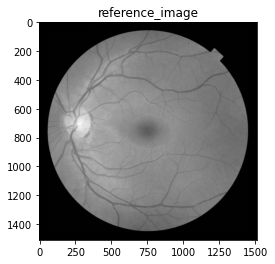

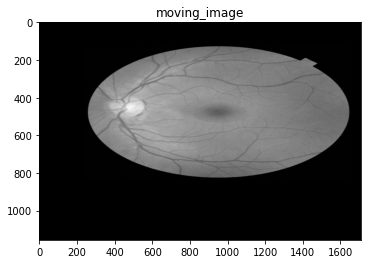

In [92]:
# Load retina image into reference_image.
reference_image = data.retina().astype(float)

# Convert reference_image to grayscale.
reference_image = np.sum(np.sqrt(reference_image**2), axis=-1)

# Pad reference_image.
reference_image = np.pad(reference_image, (50, 50))

# Create a transformed version of reference_image as moving_image.

# Make a copy of reference_image as moving_image.
moving_image = np.copy(reference_image)

# Change moving_image by changing its resolution along the first dimension.
moving_image = rescale(moving_image, (1/2, 1))

# Change moving_image's shape by adding irregular padding.
# This also changes the position of the actual object within moving_image as compared to reference_image;
# it is no longer centered.
moving_image = np.pad(moving_image, pad_width=((100, 300), (200, 0)))


# Display images.
imshow(reference_image, 'reference_image')
imshow(moving_image, 'moving_image')

### All-rigid affine-only registration
This will downsample the images by 8, then perform 100 rigid-affine-only iterations of registration.

Optional arguments:
- **multiscales**=8 --> this downsamples the images by a factor of 8 across each dimension. Here we do this for speed.
- **num_affine_only_iterations**=100 --> this sets the first 100 iterations as affine-only. No nonlinear deformation will be performed for these iterations.
- **num_rigid_affine_iterations**=100 --> this constrains the affine transform to be rigid for the first 100 iterations.
- **num_iterations**=100 --> this sets the total number of iterations to 100.

In [93]:
lddmm_output = diffeomorphic_metric_mapping(
    reference_image=reference_image,
    moving_image=moving_image,
    multiscales=8,
    num_affine_only_iterations=100,
    num_rigid_affine_iterations=100,
    num_iterations=100,
)

### Apply transforms
This deforms reference_image and moving_image into each others' spaces.

Ordinarily the user will require only one of these two transformations, possibly deforming a different image. For example, a common application in neuroscience is if you have a structural image of a subject of interest and a pair of images for a standard brain, i.e. a structural image and corresponding label image of that standard brain (i.e. an atlas), where the labeled image is an integer-valued image where particular lobes or structures within the brain share the same pixel value. By learning the registration between the subject's structural scan and the atlas's structural image, you could apply the transformation to the atlas's label image (which is in the atlas's space) and transform it into the subject's space. Incidentally, you would use the atlas as reference_image and the subject's image as moving_image. This algorithm is asymmetric and the cleaner, more representative image should be set as the reference_image.

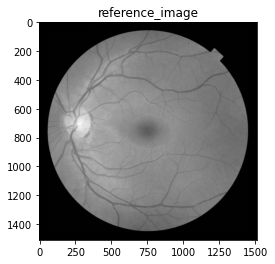

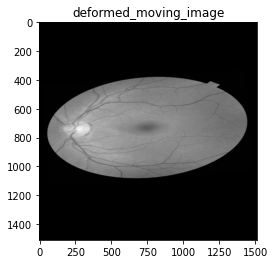

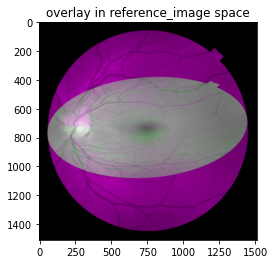

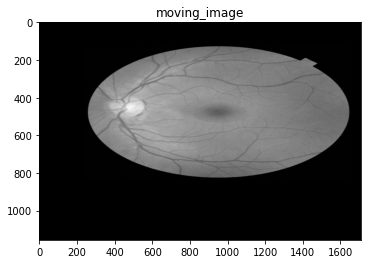

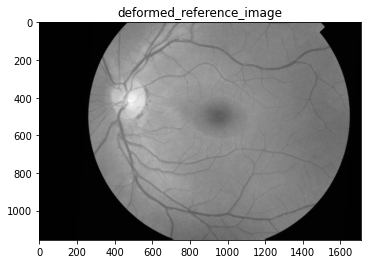

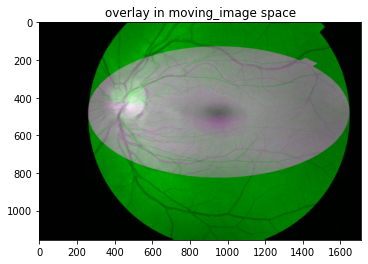

In [96]:
deformed_moving_image = map_coordinates(
        input=moving_image,
        coordinates=lddmm_output.moving_image_to_reference_image_transform,
    )
deformed_reference_image = map_coordinates(
        input=reference_image,
        coordinates=lddmm_output.reference_image_to_moving_image_transform,
    )

# Show reference_image with moving_image deformed into the reference_image space.
imshow(reference_image, 'reference_image')
imshow(deformed_moving_image, 'deformed_moving_image')
imshow_overlay(reference_image, deformed_moving_image, 'overlay in reference_image space')

# Show moving_image with the reference_image deformed into the moving_image space.
imshow(moving_image, 'moving_image')
imshow(deformed_reference_image, 'deformed_reference_image')
imshow_overlay(moving_image, deformed_reference_image, 'overlay in moving_image space')

### Discussion
This is not a good registration. As you can see, the images have been decently alligned to an extent, left-to-right (along the first dimension). Recall that a basic aligment was necessary given the initial offset. However, with this strictly rigid registration, it was not able to expand the moving_image vertically (along its second dimension), or even inflate it uniformly to achieve a compromise. All it could do was translation and rotation, and this was the result. How can this be?

moving_image was a copy of reference_image with two modifications: irregular padding, which makes a translation necessary, and downsampling along the first dimension, i.e. vertically. We could get a good registration by allowing the affine to be non-rigid, but that would imply that our moving_image was squashed. If that is correct and true to life, i.e. if moving_image was an isotropic scan of a retina sample that had been physically squashed in one direction, this would be appropriate. However, here we suppose that this apparent squashing is simply because the height of the moving_image pixels is twice as large as their width. (We have also assumed that the widths of our pixels are the same as the widths of the reference_image pixels.) Thus, while our reference_image is isotropic, our moving_image has a different resolution, or pixel-length, or spacing, along its first and second dimensions.

Next we perform the same steps but accounting for this difference.

### Set up images
The same as before, except now we define spacings (resolutions) as well.

- Load an image of a retina as reference_image
- Add uniform padding to reference_image
- Copy reference_image as moving_image
- Downsample moving_image along its first dimension
- Add irregular padding to moving_image, thus changing its resolution

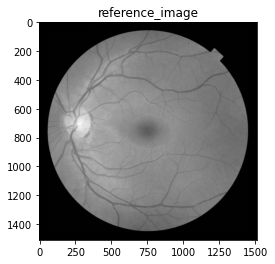

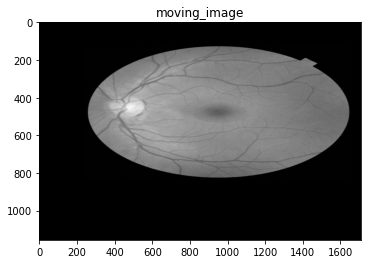

In [97]:
# Load retina image into reference_image.
reference_image = data.retina().astype(float)

# Convert reference_image to grayscale.
reference_image = np.sum(np.sqrt(reference_image**2), axis=-1)

# Pad reference_image.
reference_image = np.pad(reference_image, (50, 50))

# Create a transformed version of reference_image as moving_image.

# Make a copy of reference_image as moving_image.
moving_image = np.copy(reference_image)

# Change moving_image by changing its resolution along the first dimension.
moving_image = rescale(moving_image, (1/2, 1))

# Change moving_image's shape by adding irregular padding.
# This also changes the position of the actual object within moving_image as compared to reference_image;
# it is no longer centered.
moving_image = np.pad(moving_image, pad_width=((100, 300), (200, 0)))

# Define image spacings.

# This is equivalent to the default; it is shown for clarity.
reference_image_spacing = np.array([1, 1])

# Along the first dimension we have half the pixels representing the same amount of retina,
# so the resolution, or spacing, is twice as large.
# i.e. each pixel is twice as tall as it is wide.
moving_image_spacing = np.array([2, 1])

# Display images.
imshow(reference_image, 'reference_image')
imshow(moving_image, 'moving_image')

### All-rigid affine-only registration
This will downsample the images by 8, then perform 100 rigid-affine-only iterations of registration.

Optional arguments:
- **reference_image_spacing**=reference_image_spacing --> this specifies the spacing of the reference_image. Default is 1 isotropic.
- **moving_image_spacing**=moving_image_spacing --> this specifies the spacing of the moving_image. Default is 1 isotropic.
- **multiscales**=8 --> this downsamples the images by a factor of 8 across each dimension. Here we do this for speed.
- **num_affine_only_iterations**=100 --> this sets the first 100 iterations as affine-only. No nonlinear deformation will be performed for these iterations.
- **num_rigid_affine_iterations**=100 --> this constrains the affine transform to be rigid for the first 100 iterations.
- **num_iterations**=100 --> this sets the total number of iterations to 100.

In [98]:
lddmm_output = diffeomorphic_metric_mapping(
    reference_image=reference_image,
    moving_image=moving_image,
    reference_image_spacing=reference_image_spacing,
    moving_image_spacing=moving_image_spacing,
    multiscales=8,
    num_affine_only_iterations=100,
    num_rigid_affine_iterations=100,
    num_iterations=100,
)

### Deform reference_image and moving_image into each others' spaces

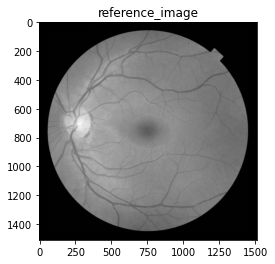

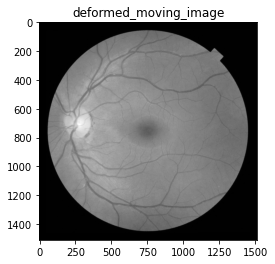

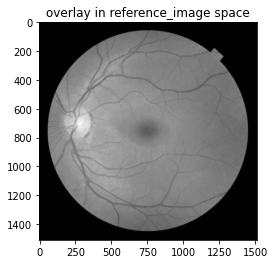

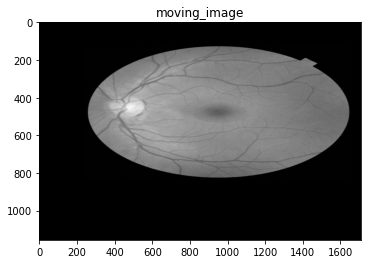

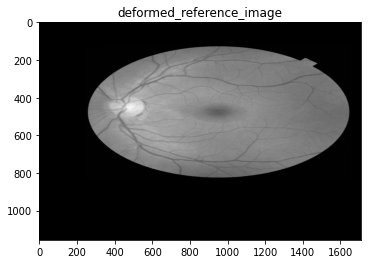

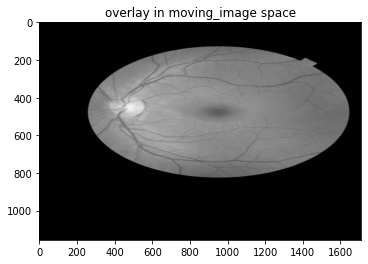

In [100]:
deformed_moving_image = map_coordinates(
        input=moving_image,
        coordinates=lddmm_output.moving_image_to_reference_image_transform,
    )
deformed_reference_image = map_coordinates(
        input=reference_image,
        coordinates=lddmm_output.reference_image_to_moving_image_transform,
    )

# Show reference_image with moving_image deformed into the reference_image space.
imshow(reference_image, 'reference_image')
imshow(deformed_moving_image, 'deformed_moving_image')
imshow_overlay(reference_image, deformed_moving_image, 'overlay in reference_image space')

# Show moving_image with the reference_image deformed into the moving_image space.
imshow(moving_image, 'moving_image')
imshow(deformed_reference_image, 'deformed_reference_image')
imshow_overlay(moving_image, deformed_reference_image, 'overlay in moving_image space')

### Discussion
This is now a good registration. As you can see, the images have been about perfectly alligned, all with the same strictly rigid affine-only registration but specifying the correct resolution. Because of this excellent alignment, the overlay images combine magenta and green into white, showing neither mismatched magenta nor green.

# Using diagnostics
In this section we begin to make use of the generate_calibration_plots function defined at the top of this tutorial. The output of the registration function, diffeomorphic_metric_mapping, is a named_tuple object that we have assigned to the variable lddmm_output (lddmm is the acronymn for the basic underlying algorithm). One of its entries is diagnostics, also a named_tuple, and it stores lists of several values that are all appended to these lists every iteration. Examining the progression of these values gives us insight into the registration's progression.

### Generate calibration plots - displays information on the registration's progression
Here we examine the calibration plots for the successful rigid registration from the preceding section. There are four plots:
- Energies - the regularization_energies and total_energies. Internally, total_energy = regularization_energy + matching_energy. regularization_energy is the penalty on unrealistic deformations, matching_energy is the sum of square error. total_energy is the overall cost that the registration process attempts to minimize.
- Maximum velocities - maximum_velocity is the norm of the largest velocity in the velocity_fields. Essentially, we use this as a metric for how far the nonlinear deformation is attempting to drag pixels by this point in the registration, after applying the affine.
- Translation components - these are the translational components of the affine.
- Linear components - these are the matrix elements of the linear transform of the affine. These together with the translation components encode the entire affine.

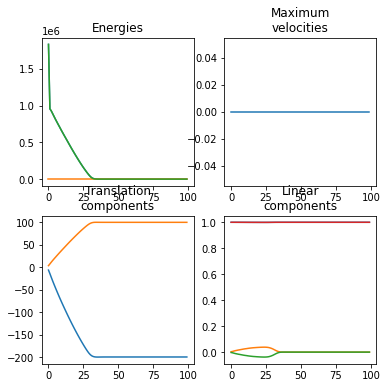

In [107]:
# Visualize registration progression, useful for parameter tuning.
generate_calibration_plots(
    affines=lddmm_output.diagnostics.affines,
    maximum_velocities=lddmm_output.diagnostics.maximum_velocities,
    matching_energies=lddmm_output.diagnostics.matching_energies,
    regularization_energies=lddmm_output.diagnostics.regularization_energies,
    total_energies=lddmm_output.diagnostics.total_energies,
)

### Discussion
First, let me explain the peculiarities of this resulting from the fact that this registration was rigid-affine-only. Since this is affine-only, the maximum velocities are zero. Since this is all-rigid, the diagonals of the affine are 1, as we see from the linear components.

Now, look at the energies plot, noting the y-axis scale. The initial alignment was very bad due to the translational offset from the moving_image's irregular padding. However, the total_energy (representing just the matching_energy since the regularization_energy is zero) converges after about 30 iterations. You'll notice that both the translations and the linear components also converge by this point.

# Tuning with deformative (nonlinear) registrations
In this section we turn to a different example, the one used to generate the gallery example for this registration method.

# Separation
# Separation
# Separation

# Tuning with deformative (nonlinear) registrations
In this section we extend our retina example by introducing a nonlinear change to moving_image that cannot be recovered using any affine-only registration.

### Set up images
Note: we apply padding so that the object doesn't touch the border of the image. When the object in the image is too close to the border, it may introduce an extrapolation issue causing a sort of smear effect. It is better to extrapolate background.

- Load an image of a retina as reference_image
- Add uniform padding to reference_image
- Copy reference_image as moving_image
- Apply a nonlinear swirl transform to moving_image
- Downsample moving_image along its first dimension
- Add irregular padding to moving_image, thus changing its resolution

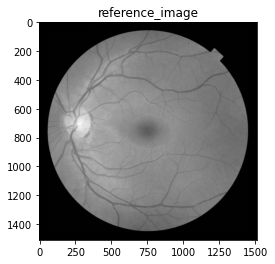

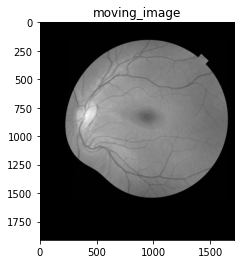

In [115]:
# Load retina image into reference_image.
reference_image = data.retina().astype(float)

# Convert reference_image to grayscale.
reference_image = np.sum(np.sqrt(reference_image**2), axis=-1)

# Pad reference_image.
reference_image = np.pad(reference_image, (50, 50))

# Create a transformed version of reference_image as moving_image.

# Make a copy of reference_image as moving_image.
moving_image = np.copy(reference_image)

# Apply a nonlinear swirl transform to moving_image.
moving_image = transform.swirl(moving_image, center=(300, 1000), strength=2, radius=1000)

# # Change moving_image by changing its resolution along the first dimension.
# moving_image = rescale(moving_image, (1/2, 1))

# Change moving_image's shape by adding irregular padding.
# This also changes the position of the actual object within moving_image as compared to reference_image;
# it is no longer centered.
moving_image = np.pad(moving_image, pad_width=((100, 300), (200, 0)))# Define spacings.


# Define image spacings.

# This is equivalent to the default; it is shown for clarity.
reference_image_spacing = np.array([1, 1])

# Along the first dimension we have half the pixels representing the same amount of retina,
# so the resolution, or spacing, is twice as large.
# i.e. each pixel is twice as tall as it is wide.
moving_image_spacing = np.array([2, 1])
moving_image_spacing = reference_image_spacing.copy()

# Display images.
imshow(reference_image, 'reference_image')
imshow(moving_image, 'moving_image')

### Deformative registration
This will downsample the images by 8, perform 50 rigid-affine-only iterations of registration, then perform another 50 iterations of joint affine and deformative iterations. The affine however will remain rigid.

Optional arguments:
- **reference_image_spacing**=reference_image_spacing --> this specifies the spacing of the reference_image. Default is 1 isotropic.
- **moving_image_spacing**=moving_image_spacing --> this specifies the spacing of the moving_image. Default is 1 isotropic.
- **multiscales**=8 --> this downsamples the images by a factor of 8 across each dimension. Here we do this for speed.
- **num_affine_only_iterations**=50 --> this sets the first 50 iterations as affine-only. No nonlinear deformation will be performed for these iterations.
- **num_rigid_affine_iterations**=100 --> this constrains the affine transform to be rigid for the first 100 iterations.
- **num_iterations**=100 --> this sets the total number of iterations to 100.

In [118]:
lddmm_output = diffeomorphic_metric_mapping(
    reference_image=reference_image,
    moving_image=moving_image,
    reference_image_spacing=reference_image_spacing,
    moving_image_spacing=moving_image_spacing,
    deformative_stepsize=300,
    multiscales=8,
    num_affine_only_iterations=50,
    num_rigid_affine_iterations=100,
    num_iterations=100,
)

### Generate calibration plots - displays information on the registration's progression

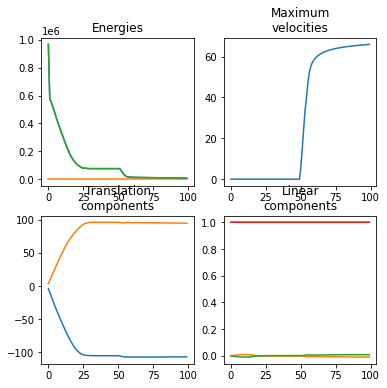

In [119]:
# Visualize registration progression, useful for parameter tuning.
generate_calibration_plots(
    affines=lddmm_output.diagnostics.affines,
    maximum_velocities=lddmm_output.diagnostics.maximum_velocities,
    matching_energies=lddmm_output.diagnostics.matching_energies,
    regularization_energies=lddmm_output.diagnostics.regularization_energies,
    total_energies=lddmm_output.diagnostics.total_energies,
)

### Deform reference_image and moving_image into each others' spaces

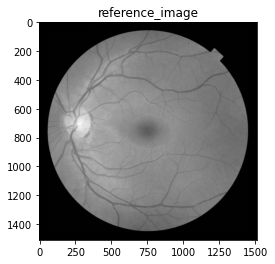

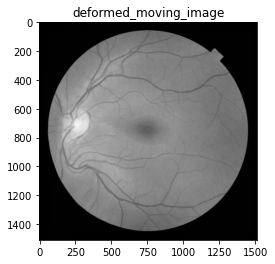

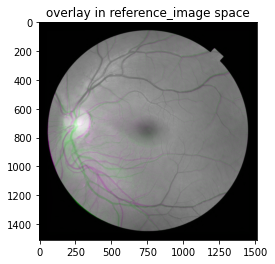

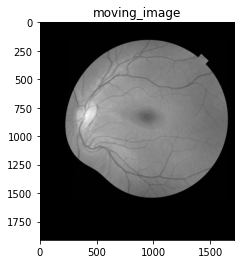

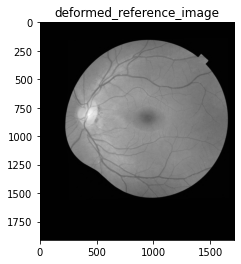

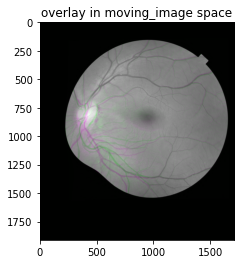

In [121]:
deformed_moving_image = map_coordinates(
        input=moving_image,
        coordinates=lddmm_output.moving_image_to_reference_image_transform,
    )
deformed_reference_image = map_coordinates(
        input=reference_image,
        coordinates=lddmm_output.reference_image_to_moving_image_transform,
    )

# Show reference_image with moving_image deformed into the reference_image space.
imshow(reference_image, 'reference_image')
imshow(deformed_moving_image, 'deformed_moving_image')
imshow_overlay(reference_image, deformed_moving_image, 'overlay in reference_image space')

# Show moving_image with the reference_image deformed into the moving_image space.
imshow(moving_image, 'moving_image')
imshow(deformed_reference_image, 'deformed_reference_image')
imshow_overlay(moving_image, deformed_reference_image, 'overlay in moving_image space')

# Separation
# Separation
# Separation

In [1]:
import numpy as np
import warnings

from scipy.linalg import inv
from scipy.interpolate import interpn
from scipy.ndimage import gaussian_filter


def _validate_scalar_to_multi(value, size=None, dtype=None, reject_nans=True):
    """
    If value's length is 1, upcast it to match size.
    Otherwise, if it does not match size, raise error.

    If size is not provided, cast to a 1-dimensional np.ndarray.

    Return a numpy array.
    """

    # Cast size to int if appropriate.
    if size is not None:
        try:
            size = int(size)
        except (TypeError, ValueError) as exception:
            raise TypeError(
                "size must be either None or interpretable as an integer.\n"
                f"type(size): {type(size)}."
            ) from exception

        if size < 0:
            raise ValueError(f"size must be non-negative.\n" f"size: {size}.")

    # Cast value to np.ndarray.
    try:
        value = np.array(value, dtype=dtype)
    except ValueError as exception:
        raise ValueError(
            "value and dtype are incompatible with one another.\n"
            f"type(value): {type(value)}, dtype: {dtype}."
        ) from exception

    # Validate value's dimensionality and length.
    if value.ndim == 0:
        value = np.array([value.item()])
    if value.ndim == 1:
        if size is not None and len(value) == 1:
            # Upcast scalar to match size.
            value = np.full(size, value, dtype=dtype)
        elif size is not None and len(value) != size:
            # value's length is incompatible with size.
            raise ValueError(
                "The length of value must either be 1 or it must match size "
                "if size is provided.\n"
                f"len(value): {len(value)}, size: {size}."
            )
    else:
        # value.ndim > 1.
        raise ValueError(
            "value must not have more than 1 dimension.\n"
            f"value.ndim: {value.ndim}."
        )

    # Check for np.nan values.
    if reject_nans and np.any(np.isnan(value)):
        raise ValueError("value contains np.nan elements.")

    return value


def _validate_ndarray(
    array,
    dtype=None,
    forbid_object_dtype=True,
    minimum_ndim=1,
    required_ndim=None,
    broadcast_to_shape=None,
    reshape_to_shape=None,
    required_shape=None,
):
    """
    Cast (a copy of) array to a np.ndarray if possible and return it
    unless it is noncompliant with minimum_ndim, required_ndim, and dtype.

    Note: the following checks and validations are performed in order.

    If required_ndim is None or 0, _validate_ndarray will accept any object.

    array is cast to an np.ndarray of type dtype.

    If minimum_ndim is provided and array.ndim < minimum_ndim, array.shape is
    left-padded by 1's until minimum_ndim is satisfied.

    If required_ndim is provided and array.ndim != required_ndim, an exception
    is raised.

    If forbid_object_dtype == True and array.dtype == object, an exception is
    raised, unless dtype is provided as object.

    If a shape is provided to broadcast_to_shape, array is broadcasted to that
    shape.

    If a shape is provided to reshape_to_shape, array is reshaped to that
    shape.

    If a shape is provided to required_shape, if the shape does not match this
    shape then an exception is raised.
    """

    # Verify arguments.

    # Verify minimum_ndim.
    if not isinstance(minimum_ndim, int):
        raise TypeError(
            f"minimum_ndim must be of type int.\n"
            f"type(minimum_ndim): {type(minimum_ndim)}."
        )
    if minimum_ndim < 0:
        raise ValueError(
            "minimum_ndim must be non-negative.\n"
            f"minimum_ndim: {minimum_ndim}."
        )

    # Verify required_ndim.
    if required_ndim is not None:
        if not isinstance(required_ndim, int):
            raise TypeError(
                f"required_ndim must be either None or of type int.\n"
                f"type(required_ndim): {type(required_ndim)}."
            )
        if required_ndim < 0:
            raise ValueError(
                f"required_ndim must be non-negative.\n"
                f"required_ndim: {required_ndim}."
            )

    # Verify dtype.
    if dtype is not None:
        if not isinstance(dtype, type):
            raise TypeError(
                f"dtype must be either None or a valid type.\n"
                f"type(dtype): {type(dtype)}."
            )

    # Validate array.

    # Cast array to np.ndarray.
    # Validate compliance with dtype.
    try:
        array = np.array(array, dtype)  # Side effect: breaks alias.
    except TypeError as exception:
        raise TypeError(
            f"array is of a type that is incompatible with dtype.\n"
            f"type(array): {type(array)}, dtype: {dtype}."
        ) from exception
    except ValueError as exception:
        raise ValueError(
            f"array has a value that is incompatible with dtype.\n"
            f"array: {array}, \ntype(array): {type(array)}, dtype: {dtype}."
        ) from exception

    # Verify compliance with forbid_object_dtype.
    if forbid_object_dtype:
        if array.dtype == object and dtype != object:
            raise TypeError(
                "Casting array to a np.ndarray produces an array of dtype "
                "object while forbid_object_dtype == True and dtype != "
                "object."
            )

    # Validate compliance with minimum_ndim by left-padding the shape with 1's
    # as necessary.
    if array.ndim < minimum_ndim:
        array = array.reshape(*[1] * (minimum_ndim - array.ndim), *array.shape)

    # Validate compliance with required_ndim.
    if required_ndim is not None and array.ndim != required_ndim:
        raise ValueError(
            "If required_ndim is not None, array.ndim must be made to equal "
            "it.\n"
            f"array.ndim: {array.ndim}, required_ndim: {required_ndim}."
        )

    # Broadcast array if appropriate.
    if broadcast_to_shape is not None:
        array = np.copy(
            np.broadcast_to(
                array=array,
                shape=broadcast_to_shape,
            )
        )

    # Reshape array if appropriate.
    if reshape_to_shape is not None:
        array = np.copy(array.reshape(reshape_to_shape))

    # Verify compliance with required_shape if appropriate.
    if required_shape is not None:
        try:
            required_shape_satisfied = np.array_equal(
                array.reshape(required_shape).shape,
                array.shape,
            )
        except ValueError as exception:
            raise ValueError(
                f"array is incompatible with required_shape.\n"
                f"array.shape: {array.shape}, "
                f"required_shape: {required_shape}."
            ) from exception
        if not required_shape_satisfied:
            raise ValueError(
                f"array is compatible with required_shape but "
                "does not match required_shape.\n"
                f"array.shape: {array.shape}, "
                f"required_shape: {required_shape}."
            )

    return array


def _validate_spacing(spacing, ndim, dtype=float):
    """
    Validate spacing to assure its length matches the dimensionality of
    image.
    """

    spacing = _validate_scalar_to_multi(spacing, size=ndim, dtype=dtype)

    if np.any(spacing <= 0):
        raise ValueError(
            f"All elements of spacing must be positive.\n"
            f"np.min(spacing): {np.min(spacing)}."
        )

    return spacing


def _compute_axes(shape, spacing=1, origin="center"):
    """
    Returns the real_axes defining an image with the given shape
    at the given spacing as a list of numpy arrays.
    """

    # Validate shape.
    shape = _validate_ndarray(shape, dtype=int, required_ndim=1)

    # Validate spacing.
    spacing = _validate_spacing(spacing, len(shape))

    # Create axes.

    # axes is a list of arrays matching each shape element from shape, spaced
    # by the corresponding spacing.
    axes = [
        np.arange(dim_size) * dim_res
        for dim_size, dim_res in zip(shape, spacing)
    ]

    # List all presently recognized origin values.
    origins = ["center", "zero"]

    if origin == "center":
        # Center each axes array to its mean.
        for axis_index, axis in enumerate(axes):
            axes[axis_index] -= np.mean(axis)
    elif origin == "zero":
        # Allow each axis to increase from 0 along each dimension.
        pass
    else:
        raise NotImplementedError(
            f"origin must be one of these supported values: {origins}.\n"
            f"origin: {origin}."
        )

    return axes


def _compute_coords(shape, spacing=1, origin="center"):
    """
    Returns the real_coordinates of an image with the given shape at the given
    spacing as a single numpy array of shape (*shape, len(shape)).
    """

    axes = _compute_axes(shape, spacing, origin)

    meshes = np.meshgrid(*axes, indexing="ij")

    return np.stack(meshes, axis=-1)


def _multiply_coords_by_affine(affine, array):
    """
    Applies affine to the elements of array at each spatial position and
    returns the result.
    """

    # Validate inputs.

    # Verify that affine is square.
    if affine.ndim != 2:
        raise ValueError(
            f"affine must be a 2-dimensional matrix.\n"
            f"affine.ndim: {affine.ndim}."
        )
    # affine is 2-dimensional.
    if affine.shape[0] != affine.shape[1]:
        raise ValueError(
            f"affine must be a square matrix.\n"
            f"affine.shape: {affine.shape}."
        )
    # affine is square.

    # Verify compatibility between affine and array.
    if array.shape[-1] != len(affine) - 1:
        raise ValueError(
            "array is incompatible with affine. The length of the last "
            "dimension of array should be 1 less than the length of affine.\n"
            f"array.shape: {array.shape}, affine.shape: {affine.shape}."
        )

    # Raise warning if affine is not in homogenous coordinates.
    if not np.array_equal(
        affine[-1],
        np.array([0] * (len(affine) - 1) + [1]),
    ):
        warnings.warn(
            message=f"affine is not in homogenous coordinates.\n"
            f"affine[-1] should be zeros with a 1 on the right.\n"
            f"affine[-1]: {affine[-1]}.",
            category=RuntimeWarning,
        )

    # Perform affine matrix multiplication.

    ndims = len(affine) - 1
    return (
        np.squeeze(np.matmul(affine[:ndims, :ndims], array[..., None]), -1)
        + affine[:ndims, ndims]
    )


def _compute_tail_determinant(array):
    """
    Computes and returns the determinant of array along its last 2 dimensions.
    """

    # Validate that array is square on its last 2 dimensions.
    if array.shape[-1] != array.shape[-2]:
        raise ValueError(
            f"array must be square on its last 2 dimensions.\n"
            f"array.shape[-2:]: {array.shape[-2:]}."
        )

    # Compute the determinant recursively.

    if array.shape[-1] == 2:
        # Handle 2-dimensional base case.
        determinant = (
            array[..., 0, 0] * array[..., 1, 1]
            - array[..., 0, 1] * array[..., 1, 0]
        )
    else:
        # Handle more than 2-dimensional recursive case.
        determinant = 0
        for dim in range(array.shape[-1]):
            recursive_indices = list(range(array.shape[-1]))
            recursive_indices.remove(dim)
            determinant += (
                (-1) ** dim
                * array[..., 0, dim]
                * _compute_tail_determinant(array[..., 1:, recursive_indices])
            )

    return determinant


def resample(
    image,
    new_spacing,
    old_spacing=1,
    err_to_larger=True,
    extrapolation_fill_value=None,
    origin="center",
    method="linear",
    image_is_coords=False,
    anti_aliasing=True,
):
    """
    Resamples image from an old spacing to a new spacing.

    Parameters
    ----------
    image: np.ndarray
        The image to be resampled
    new_spacing: float, seq
        The spacing of the resampled image.
    old_spacing: float, seq, optional
        The spacing of the input image. By default 1.
    err_to_larger: bool, optional
        Determines whether to round the new shape up or down.
        By default True.
    extrapolation_fill_value: float, optional
        The fill_value kwarg passed to interpn. By default None.
    origin: str, optional
        The origin to use for the image axes and coordinates used
        internally. By default 'center'.
    method: str, optional
        The method of interpolation, passed as the method kwarg in
        interpn. By default 'linear'.
    image_is_coords: bool, optional
        If True, this implies that the last dimension of image is not a
        spatial dimension and not subject to interpolation.
        By default False.
    anti_aliasing: bool, optional
        If True, applies a gaussian filter across dimensions to be
        downsampled before interpolating. By default True.

    Returns
    -------
    np.ndarray
        The result of resampling image at new_spacing.

    """

    # Validate inputs and define ndim & old_shape based on image_is_coords.
    image = _validate_ndarray(image)  # Breaks alias.
    if image_is_coords:
        ndim = image.ndim - 1
        old_shape = image.shape[:-1]
    else:
        ndim = image.ndim
        old_shape = image.shape
    new_spacing = _validate_spacing(new_spacing, ndim)
    old_spacing = _validate_spacing(old_spacing, ndim)

    # Handle trivial case.
    if np.array_equal(new_spacing, old_spacing):
        # Note: this is a copy of the input image and is not the same object.
        return image

    # Compute new_coords and old_axes.
    if err_to_larger:
        new_shape = np.ceil(old_shape * old_spacing / new_spacing)
    else:
        new_shape = np.floor(old_shape * old_spacing / new_spacing)
    new_coords = _compute_coords(new_shape, new_spacing, origin)
    old_axes = _compute_axes(old_shape, old_spacing, origin)

    # Apply anti-aliasing gaussian filter if downsampling.
    if anti_aliasing:
        if image_is_coords:
            downsample_factors = np.insert(
                old_shape / new_shape, image.ndim - 1, values=0, axis=0
            )
        else:
            downsample_factors = old_shape / new_shape
        anti_aliasing_sigma = np.maximum(0, (downsample_factors - 1) / 2)
        gaussian_filter(
            image, anti_aliasing_sigma, output=image, mode="nearest"
        )  # Mutates image.

    # Interpolate image.
    new_image = interpn(
        points=old_axes,
        values=image,
        xi=new_coords,
        bounds_error=False,
        fill_value=extrapolation_fill_value,
    )

    return new_image


def sinc_resample(array, new_shape):
    """
    Resample array to new_shape by padding and truncating at high frequencies
    in the fourier domain.

    Parameters
    ----------
    array : np.ndarray
        The array to be resampled.
    new_shape : seq
        The shape to resample array to.

    Returns
    -------
    np.ndarray
        A copy of array after resampling.
    """

    # Validate inputs.
    array = _validate_ndarray(array)
    new_shape = _validate_ndarray(
        new_shape, dtype=int, required_ndim=1, required_shape=array.ndim
    )

    resampled_array = np.copy(array)

    for dim in range(array.ndim):
        fourier_transformed_array = np.fft.rfft(resampled_array, axis=dim)
        resampled_array = np.fft.irfft(
            fourier_transformed_array, axis=dim, n=new_shape[dim]
        )
    resampled_array *= resampled_array.size / array.size

    return resampled_array


def generate_position_field(
    affine,
    velocity_fields,
    velocity_field_spacing,
    reference_image_shape,
    reference_image_spacing,
    moving_image_shape,
    moving_image_spacing,
    deform_to="reference_image",
):
    """
    Integrate velocity_fields and apply affine to produce a position field.

    Parameters
    ----------
    affine : np.ndarray
        The affine array to be incorporated into the returned position field.
    velocity_fields : np.ndarray
        The velocity_fields defining the diffeomorphic flow. The leading
        dimensions are spatial, and the last two dimensions are the number of
        time steps and the coordinates.
    velocity_field_spacing : float, seq
        The spacing of velocity_fields, with multiple values given to
        specify anisotropy.
    reference_image_shape : seq
        The shape of the reference_image.
    reference_image_spacing : float, seq
        The spacing of the reference_image, with multiple values given to
        specify anisotropy.
    moving_image_shape : seq
        The shape of the moving_image.
    moving_image_spacing : float, seq
        The spacing of the moving_image, with multiple values given to
        specify anisotropy.
    deform_to : str, optional
        The direction of the deformation. By default "reference_image".

    Returns
    -------
    np.ndarray
        The position field for the registration in the space of the image
        specified by deform_to.

    Raises
    ------
    ValueError
        Raised if the leading dimensions of velocity_fields fail to match
        reference_image_shape.
    TypeError
        Raised if deform_to is not of type str.
    ValueError
        Raised if deform_to is neither 'reference_image' nor 'moving_image'.
    """

    # Validate inputs.
    # Validate reference_image_shape. Not rigorous.
    reference_image_shape = _validate_ndarray(reference_image_shape)
    # Validate moving_image_shape. Not rigorous.
    moving_image_shape = _validate_ndarray(moving_image_shape)
    # Validate velocity_fields.
    velocity_fields = _validate_ndarray(
        velocity_fields, required_ndim=len(reference_image_shape) + 2
    )
    if not np.all(velocity_fields.shape[:-2] == reference_image_shape):
        raise ValueError(
            "velocity_fields' initial dimensions must equal "
            "reference_image_shape.\n"
            f"velocity_fields.shape: {velocity_fields.shape}, "
            f"reference_image_shape: {reference_image_shape}."
        )
    # Validate velocity_field_spacing.
    velocity_field_spacing = _validate_spacing(
        velocity_field_spacing, velocity_fields.ndim - 2
    )
    # Validate affine.
    affine = _validate_ndarray(
        affine,
        required_ndim=2,
        reshape_to_shape=(
            len(reference_image_shape) + 1,
            len(reference_image_shape) + 1,
        ),
    )
    # Verify deform_to.
    if not isinstance(deform_to, str):
        raise TypeError(
            f"deform_to must be of type str.\n"
            f"type(deform_to): {type(deform_to)}."
        )
    elif deform_to not in ["reference_image", "moving_image"]:
        raise ValueError(
            "deform_to must be either 'reference_image'" "or 'moving_image'."
        )

    # Compute intermediates.
    num_timesteps = velocity_fields.shape[-2]
    delta_t = 1 / num_timesteps
    reference_image_axes = _compute_axes(
        reference_image_shape,
        reference_image_spacing,
    )
    reference_image_coords = _compute_coords(
        reference_image_shape,
        reference_image_spacing,
    )
    moving_image_axes = _compute_axes(
        moving_image_shape,
        moving_image_spacing,
    )
    moving_image_coords = _compute_coords(
        moving_image_shape,
        moving_image_spacing,
    )

    # Create position field.
    if deform_to == "reference_image":
        phi = np.copy(reference_image_coords)
    elif deform_to == "moving_image":
        phi_inv = np.copy(reference_image_coords)

    # Integrate velocity field.
    for timestep in (
        reversed(range(num_timesteps))
        if deform_to == "reference_image"
        else range(num_timesteps)
    ):
        if deform_to == "reference_image":
            sample_coords = (
                reference_image_coords
                + velocity_fields[..., timestep, :] * delta_t
            )
            phi = (
                interpn(
                    points=reference_image_axes,
                    values=phi - reference_image_coords,
                    xi=sample_coords,
                    bounds_error=False,
                    fill_value=None,
                )
                + sample_coords
            )
        elif deform_to == "moving_image":
            sample_coords = (
                reference_image_coords
                - velocity_fields[..., timestep, :] * delta_t
            )
            phi_inv = (
                interpn(
                    points=reference_image_axes,
                    values=phi_inv - reference_image_coords,
                    xi=sample_coords,
                    bounds_error=False,
                    fill_value=None,
                )
                + sample_coords
            )

    # Apply the affine transform to the position field.
    if deform_to == "reference_image":
        # Apply the affine by multiplication.
        affine_phi = _multiply_coords_by_affine(affine, phi)
        # affine_phi has the spacing of the reference_image.
    elif deform_to == "moving_image":
        # Apply the affine by interpolation.
        sample_coords = _multiply_coords_by_affine(
            inv(affine),
            moving_image_coords,
        )
        phi_inv_affine_inv = (
            interpn(
                points=reference_image_axes,
                values=phi_inv - reference_image_coords,
                xi=sample_coords,
                bounds_error=False,
                fill_value=None,
            )
            + sample_coords
        )
        # phi_inv_affine_inv has the spacing of the moving_image.

    # return appropriate position field.
    if deform_to == "reference_image":
        return affine_phi
    elif deform_to == "moving_image":
        return phi_inv_affine_inv


In [2]:
"""
This is an implementation of the LDDMM algorithm with modifications, written
by Devin Crowley and based on "Diffeomorphic registration with intensity
transformation and missing data: Application to 3D digital pathology of
Alzheimer's disease."

This paper extends on an older LDDMM paper, "Computing large deformation
metric mappings via geodesic flows of diffeomorphisms."

This is the more recent paper:
Tward, Daniel, et al. "Diffeomorphic registration with intensity
transformation and missing data: Application to 3D digital pathology of
Alzheimer's disease." Frontiers in neuroscience 14 (2020).
https://doi.org/10.3389/fnins.2020.00052

This is the original LDDMM paper:
Beg, M. Faisal, et al. "Computing large deformation metric mappings via
geodesic flows of diffeomorphisms." International journal of computer vision
61.2 (2005): 139-157.
https://doi.org/10.1023/B:VISI.0000043755.93987.aa
"""

import warnings
import numpy as np
from collections import namedtuple

from scipy.interpolate import interpn
from scipy.linalg import inv, solve, det, svd
from skimage.transform import resize, rescale

# from ._lddmm_utilities import _validate_scalar_to_multi
# from ._lddmm_utilities import _validate_ndarray
# from ._lddmm_utilities import _validate_spacing
# from ._lddmm_utilities import _compute_axes
# from ._lddmm_utilities import _compute_coords
# from ._lddmm_utilities import _multiply_coords_by_affine
# from ._lddmm_utilities import _compute_tail_determinant
# from ._lddmm_utilities import resample
# from ._lddmm_utilities import sinc_resample

r"""
  _            _       _
 | |          | |     | |
 | |        __| |   __| |  _ __ ___    _ __ ___
 | |       / _` |  / _` | | '_ ` _ \  | '_ ` _ \
 | |____  | (_| | | (_| | | | | | | | | | | | | |
 |______|  \__,_|  \__,_| |_| |_| |_| |_| |_| |_|

"""


class _Lddmm:
    """
    Class for storing shared values and objects used in learning a
    registration at a single scale.
    """

    def __init__(
        self,
        # Images.
        reference_image,
        moving_image,
        # Image spacings.
        reference_image_spacing=None,
        moving_image_spacing=None,
        # Iterations.
        num_iterations=None,
        num_affine_only_iterations=None,
        num_rigid_affine_iterations=None,
        # Stepsizes.
        affine_stepsize=None,
        deformative_stepsize=None,
        # Affine specifiers.
        fixed_affine_scale=None,
        # Velocity field specifiers.
        sigma_regularization=None,
        velocity_smooth_length=None,
        preconditioner_velocity_smooth_length=None,
        maximum_velocity_fields_update=None,
        num_timesteps=None,
        # Contrast map specifiers.
        contrast_order=None,
        spatially_varying_contrast_map=None,
        contrast_iterations=None,
        sigma_contrast=None,
        contrast_smooth_length=None,
        # Smoothness vs. accuracy tradeoff.
        sigma_matching=None,
        # Classification specifiers.
        artifact_and_background_classification=None,
        sigma_artifact=None,
        sigma_background=None,
        artifact_prior=None,
        background_prior=None,
        # Initial values.
        initial_affine=None,
        initial_contrast_coefficients=None,
        initial_velocity_fields=None,
        # Diagnostic accumulators.
        affines=None,
        maximum_velocities=None,
        matching_energies=None,
        regularization_energies=None,
        total_energies=None,
    ):

        # Constant inputs.

        # Images.
        self.reference_image = _validate_ndarray(reference_image, dtype=float)
        self.moving_image = _validate_ndarray(
            moving_image, dtype=float, required_ndim=self.reference_image.ndim
        )

        # spacing.
        self.reference_image_spacing = _validate_scalar_to_multi(
            reference_image_spacing
            if reference_image_spacing is not None
            else 1,
            self.reference_image.ndim,
            float,
        )
        self.moving_image_spacing = _validate_scalar_to_multi(
            moving_image_spacing if moving_image_spacing is not None else 1,
            self.moving_image.ndim,
            float,
        )

        # Iterations.
        self.num_iterations = (
            int(num_iterations) if num_iterations is not None else 300
        )
        self.num_affine_only_iterations = (
            int(num_affine_only_iterations)
            if num_affine_only_iterations is not None
            else 100
        )
        self.num_rigid_affine_iterations = (
            int(num_rigid_affine_iterations)
            if num_rigid_affine_iterations is not None
            else 50
        )

        # Stepsizes.
        self.affine_stepsize = (
            float(affine_stepsize) if affine_stepsize is not None else 0.3
        )
        self.deformative_stepsize = (
            float(deformative_stepsize)
            if deformative_stepsize is not None
            else 0
        )

        # Affine specifiers.
        self.fixed_affine_scale = (
            float(fixed_affine_scale)
            if fixed_affine_scale is not None
            else None
        )

        # Velocity field specifiers.
        self.sigma_regularization = (
            float(sigma_regularization)
            if sigma_regularization is not None
            else np.inf
        )
        self.velocity_smooth_length = (
            float(velocity_smooth_length)
            if velocity_smooth_length is not None
            else 2 * np.max(self.reference_image_spacing)
        )
        self.preconditioner_velocity_smooth_length = (
            float(preconditioner_velocity_smooth_length)
            if preconditioner_velocity_smooth_length is not None
            else 0
        )  # Default is inactive.
        self.maximum_velocity_fields_update = (
            float(maximum_velocity_fields_update)
            if maximum_velocity_fields_update is not None
            else np.max(
                self.reference_image.shape * self.reference_image_spacing
            )
        )  # Default is effectively inactive.
        self.num_timesteps = (
            int(num_timesteps) if num_timesteps is not None else 5
        )

        # Contrast map specifiers.
        self.contrast_order = int(contrast_order) if contrast_order else 1
        if self.contrast_order < 1:
            raise ValueError(
                "contrast_order must be at least 1.\n"
                f"contrast_order: {self.contrast_order}"
            )
        self.spatially_varying_contrast_map = (
            bool(spatially_varying_contrast_map)
            if spatially_varying_contrast_map is not None
            else False
        )
        self.contrast_iterations = (
            int(contrast_iterations) if contrast_iterations else 5
        )
        self.sigma_contrast = float(sigma_contrast) if sigma_contrast else 1
        self.contrast_smooth_length = (
            float(contrast_smooth_length)
            if contrast_smooth_length
            else 10 * np.max(self.moving_image_spacing)
        )

        # Smoothness vs. accuracy tradeoff.
        self.sigma_matching = (
            float(sigma_matching)
            if sigma_matching
            else np.std(self.moving_image)
        )

        # Classification specifiers.
        self.artifact_and_background_classification = (
            bool(artifact_and_background_classification)
            if artifact_and_background_classification is not None
            else False
        )
        self.sigma_artifact = (
            float(sigma_artifact)
            if sigma_artifact
            else 5 * self.sigma_matching
        )
        self.sigma_background = (
            float(sigma_background)
            if sigma_background
            else 2 * self.sigma_matching
        )
        self.artifact_prior = (
            float(artifact_prior) if artifact_prior is not None else 1 / 3
        )
        self.background_prior = (
            float(background_prior) if background_prior is not None else 1 / 3
        )
        if self.artifact_prior + self.background_prior >= 1:
            raise ValueError(
                "artifact_prior and background_prior must sum to less than 1."
            )

        # Diagnostic accumulators.
        self.affines = list(affines) if affines is not None else []
        self.maximum_velocities = (
            list(maximum_velocities) if maximum_velocities is not None else []
        )
        self.maximum_velocities += [0] * self.num_affine_only_iterations
        self.matching_energies = (
            list(matching_energies) if matching_energies is not None else []
        )
        self.regularization_energies = (
            list(regularization_energies)
            if regularization_energies is not None
            else []
        )
        self.total_energies = (
            list(total_energies) if total_energies is not None else []
        )

        # Constructions.

        # Constants.
        self.reference_image_axes = _compute_axes(
            self.reference_image.shape, self.reference_image_spacing
        )
        self.reference_image_coords = _compute_coords(
            self.reference_image.shape, self.reference_image_spacing
        )
        self.moving_image_axes = _compute_axes(
            self.moving_image.shape, self.moving_image_spacing
        )
        self.moving_image_coords = _compute_coords(
            self.moving_image.shape, self.moving_image_spacing
        )
        self.artifact_mean_value = np.max(self.moving_image)
        self.background_mean_value = np.min(self.moving_image)
        self.delta_t = 1 / self.num_timesteps
        self.fourier_filter_power = 2
        fourier_velocity_fields_coords = _compute_coords(
            self.reference_image.shape,
            1 / (self.reference_image_spacing * self.reference_image.shape),
            origin="zero",
        )
        self.fourier_high_pass_filter = (
            1
            - self.velocity_smooth_length ** 2
            * np.sum(
                (
                    -2
                    + 2
                    * np.cos(
                        2
                        * np.pi
                        * fourier_velocity_fields_coords
                        * self.reference_image_spacing
                    )
                )
                / self.reference_image_spacing ** 2,
                axis=-1,
            )
        ) ** self.fourier_filter_power
        fourier_reference_image_coords = _compute_coords(
            self.reference_image.shape,
            1 / (self.reference_image_spacing * self.reference_image.shape),
            origin="zero",
        )
        self.low_pass_filter = 1 / (
            (
                1
                - self.velocity_smooth_length ** 2
                * (
                    np.sum(
                        (
                            -2
                            + 2
                            * np.cos(
                                2
                                * np.pi
                                * self.reference_image_spacing
                                * fourier_reference_image_coords
                            )
                        )
                        / self.reference_image_spacing ** 2,
                        -1,
                    )
                )
            )
            ** (2 * self.fourier_filter_power)
        )
        # This filter affects the optimization but not the optimum.
        self.preconditioner_low_pass_filter = 1 / (
            (
                1
                - self.preconditioner_velocity_smooth_length ** 2
                * (
                    np.sum(
                        (
                            -2
                            + 2
                            * np.cos(
                                2
                                * np.pi
                                * self.reference_image_spacing
                                * fourier_reference_image_coords
                            )
                        )
                        / self.reference_image_spacing ** 2,
                        -1,
                    )
                )
            )
            ** (2 * self.fourier_filter_power)
        )
        fourier_moving_image_coords = _compute_coords(
            self.moving_image.shape,
            1 / (self.moving_image_spacing * self.moving_image.shape),
            origin="zero",
        )
        self.contrast_high_pass_filter = (
            1
            - self.contrast_smooth_length ** 2
            * (
                np.sum(
                    (
                        -2
                        + 2
                        * np.cos(
                            2
                            * np.pi
                            * self.moving_image_spacing
                            * fourier_moving_image_coords
                        )
                    )
                    / self.moving_image_spacing ** 2,
                    -1,
                )
            )
        ) ** self.fourier_filter_power / self.sigma_contrast

        # Dynamics.
        if initial_affine is None:
            initial_affine = np.eye(reference_image.ndim + 1)
        self.affine = _validate_ndarray(
            initial_affine,
            required_shape=(
                self.reference_image.ndim + 1,
                self.reference_image.ndim + 1,
            ),
        )
        if initial_velocity_fields is not None:
            self.velocity_fields = _validate_ndarray(
                initial_velocity_fields,
                required_shape=(
                    *self.reference_image.shape,
                    self.num_timesteps,
                    self.reference_image.ndim,
                ),
            )
        else:
            self.velocity_fields = np.zeros(
                (
                    *self.reference_image.shape,
                    self.num_timesteps,
                    self.reference_image.ndim,
                )
            )
        # Note: If a transformation T maps a point in the space of the
        # reference_image to a point in the space of the moving_image, as
        # affine_phi, the reference_image image is deformed using T_inv, or
        # phi_inv_affine_inv via interpolation of the moving_image at
        # phi_inv_affine_inv.
        # phi: A position-field that describes change in shape, or
        # deformation, of the reference_image but not change in scale or
        # orientation. Stored in reference_image-space.
        self.phi = np.copy(self.reference_image_coords)
        # affine_phi: A position-field that composes of phi then affine that
        # describes change in shape, i.e. deformation, and change in scale
        # and orientation. Stored in reference_image-space. This is used for
        # transforming images in moving_image-space to reference_image-space by
        # interpolation.
        self.affine_phi = np.copy(self.reference_image_coords)
        # phi_inv: A position-field that describes the inverse change in
        # shape, or deformation, of the reference_image but not change in scale
        # or orientation. Stored in reference_image-space.
        self.phi_inv = np.copy(self.reference_image_coords)
        # phi_inv_affine_inv: A position-field that composes affine_inv then
        # phi_inv that describes change in shape, i.e. deformation, and
        # change in scale and orientation. Stored in moving_image-space. This
        # is used for transforming images in reference_image-space to
        # moving_image-space by interpolation.
        self.phi_inv_affine_inv = np.copy(self.moving_image_coords)
        self.fourier_velocity_fields = np.zeros_like(
            self.velocity_fields, np.complex128
        )
        self.matching_weights = np.ones_like(self.moving_image)
        self.deformed_reference_image_to_time = []
        self.deformed_reference_image = interpn(
            points=self.reference_image_axes,
            values=self.reference_image,
            xi=self.phi_inv_affine_inv,
            bounds_error=False,
            fill_value=None,
        )
        if spatially_varying_contrast_map:
            if initial_contrast_coefficients is None:
                self.contrast_coefficients = np.zeros(
                    (*self.moving_image.shape, self.contrast_order + 1)
                )
            else:
                self.contrast_coefficients = _validate_ndarray(
                    initial_contrast_coefficients,
                    broadcast_to_shape=(
                        *self.moving_image.shape,
                        self.contrast_order + 1,
                    ),
                )
        else:
            if initial_contrast_coefficients is None:
                self.contrast_coefficients = np.zeros(self.contrast_order + 1)
            else:
                self.contrast_coefficients = _validate_ndarray(
                    initial_contrast_coefficients,
                    required_shape=(self.contrast_order + 1),
                )
        self.contrast_coefficients[..., 0] = np.mean(
            self.moving_image
        ) - np.mean(self.reference_image) * np.std(self.moving_image) / np.std(
            self.reference_image
        )
        if self.contrast_order > 0:
            self.contrast_coefficients[..., 1] = np.std(
                self.moving_image
            ) / np.std(self.reference_image)
        self.contrast_polynomial_basis = np.empty(
            (*self.moving_image.shape, self.contrast_order + 1)
        )
        for power in range(self.contrast_order + 1):
            self.contrast_polynomial_basis[..., power] = (
                self.deformed_reference_image ** power
            )
        self.contrast_deformed_reference_image = np.sum(
            self.contrast_polynomial_basis * self.contrast_coefficients,
            axis=-1,
        )  # Initialized value not used.

        # Preempt known error.
        if np.any(np.array(self.reference_image.shape) == 1) or np.any(
            np.array(self.moving_image.shape) == 1
        ):
            raise RuntimeError(
                "Known issue: Images with a 1 in their shape are not "
                "supported by scipy.interpolate.interpn.\n"
                f"self.reference_image.shape: {self.reference_image.shape},"
                f"self.moving_image.shape: {self.moving_image.shape}.\n"
            )

    def register(self):
        """
        Register the reference_image to the moving_image using the current
        state of the attributes.

        Return a dictionary of relevant quantities most notably including the
        transformations:
            phi_inv_affine_inv is the position field that maps the
            reference_image to the moving_image.
            affine_phi is the position field that maps the moving_image to the
                reference_image.
        """

        # Iteratively perform each step of the registration.
        for iteration in range(self.num_iterations):

            # Forward pass: apply transforms to the reference_image and
            # compute the costs.

            # Compute position_field from velocity_fields.
            self._update_and_apply_position_field()
            # Contrast transform the deformed_reference_image.
            self._apply_contrast_map()
            # Compute weights.
            # This is the expectation step of the expectation maximization
            # algorithm.
            # Note: recomputing weights may be appropriate less frequently
            # than every iteration.
            if self.artifact_and_background_classification:
                self._compute_weights()
            # Compute cost.
            self._compute_cost()

            # Backward pass: update contrast map, affine, & velocity_fields.

            # Compute contrast map.
            self._compute_contrast_map()

            # Compute affine gradient.
            affine_inv_gradient = self._compute_affine_inv_gradient()
            # Compute velocity_fields gradient.
            if iteration >= self.num_affine_only_iterations:
                velocity_fields_gradients = (
                    self._compute_velocity_fields_gradients()
                )
            # Update affine.
            self._update_affine(
                affine_inv_gradient, iteration
            )  # rigid_only=iteration < self.rigid_only_iterations)
            # Update velocity_fields.
            if iteration >= self.num_affine_only_iterations:
                self._update_velocity_fields(velocity_fields_gradients)
        # End for loop.

        # Compute affine_phi in case there were only affine-only iterations.
        self._compute_affine_phi()

    def _update_and_apply_position_field(self):
        """
        Calculate phi_inv from v
        Compose on the right with Ainv
        Apply phi_inv_affine_inv to reference_image

        Accesses attributes:
            reference_image
            reference_image_axes
            reference_image_coords
            moving_image_coords
            num_timesteps
            delta_t
            affine
            velocity_fields
            phi_inv
            phi_inv_affine_inv
            deformed_reference_image_to_time
            deformed_reference_image

        Updates attributes:
            phi_inv
            phi_inv_affine_inv
            deformed_reference_image_to_time
            deformed_reference_image
        """

        # Set self.phi_inv to identity.
        self.phi_inv = np.copy(self.reference_image_coords)

        # Reset self.deformed_reference_image_to_time.
        self.deformed_reference_image_to_time = []
        for timestep in range(self.num_timesteps):
            # Compute phi_inv.
            sample_coords = (
                self.reference_image_coords
                - self.velocity_fields[..., timestep, :] * self.delta_t
            )
            self.phi_inv = (
                interpn(
                    points=self.reference_image_axes,
                    values=self.phi_inv - self.reference_image_coords,
                    xi=sample_coords,
                    bounds_error=False,
                    fill_value=None,
                )
                + sample_coords
            )

            # Compute deformed_reference_image_to_time
            self.deformed_reference_image_to_time.append(
                interpn(
                    points=self.reference_image_axes,
                    values=self.reference_image,
                    xi=self.phi_inv,
                    bounds_error=False,
                    fill_value=None,
                )
            )

            # End time loop.

        # Apply affine_inv to moving_image_coords by multiplication.
        affine_inv_moving_image_coords = _multiply_coords_by_affine(
            inv(self.affine), self.moving_image_coords
        )

        # Apply phi_inv to affine_inv_moving_image_coords.
        self.phi_inv_affine_inv = (
            interpn(
                points=self.reference_image_axes,
                values=self.phi_inv - self.reference_image_coords,
                xi=affine_inv_moving_image_coords,
                bounds_error=False,
                fill_value=None,
            )
            + affine_inv_moving_image_coords
        )

        # Apply phi_inv_affine_inv to reference_image.
        # deformed_reference_image is sampled at the coordinates of the
        # moving_image.
        self.deformed_reference_image = interpn(
            points=self.reference_image_axes,
            values=self.reference_image,
            xi=self.phi_inv_affine_inv,
            bounds_error=False,
            fill_value=None,
        )

    def _apply_contrast_map(self):
        """
        Apply contrast_coefficients to deformed_reference_image to produce
        contrast_deformed_reference_image.

        Accsses attributes:
            contrast_polynomial_basis
            contrast_coefficients
            contrast_deformed_reference_image


        Updates attributes:
            contrast_deformed_reference_image
        """

        self.contrast_deformed_reference_image = np.sum(
            self.contrast_polynomial_basis * self.contrast_coefficients,
            axis=-1,
        )

    def _compute_weights(self):
        """
        Compute the matching_weights between the
        contrast_deformed_reference_image and the moving_image.

        Accsses attributes:
            moving_image
            sigma_matching
            sigma_artifact
            sigma_background
            artifact_prior
            background_prior
            contrast_deformed_reference_image
            artifact_mean_value
            background_mean_value
            matching_weights

        Updates attributes:
            artifact_mean_value
            background_mean_value
            matching_weights
        """

        likelihood_matching = np.exp(
            (self.contrast_deformed_reference_image - self.moving_image) ** 2
            * (-1 / (2 * self.sigma_matching ** 2))
        ) / np.sqrt(2 * np.pi * self.sigma_matching ** 2)
        likelihood_artifact = np.exp(
            (self.artifact_mean_value - self.moving_image) ** 2
            * (-1 / (2 * self.sigma_artifact ** 2))
        ) / np.sqrt(2 * np.pi * self.sigma_artifact ** 2)
        likelihood_background = np.exp(
            (self.background_mean_value - self.moving_image) ** 2
            * (-1 / (2 * self.sigma_background ** 2))
        ) / np.sqrt(2 * np.pi * self.sigma_background ** 2)

        # Account for priors.
        likelihood_matching *= 1 - self.artifact_prior - self.background_prior
        likelihood_artifact *= self.artifact_prior
        likelihood_background *= self.background_prior

        # Where the denominator is less than 1e-6 of its maximum, set it to
        # 1e-6 of its maximum to avoid division by zero.
        likelihood_sum = (
            likelihood_matching + likelihood_artifact + likelihood_background
        )
        likelihood_sum_max = np.max(likelihood_sum)
        likelihood_sum[likelihood_sum < 1e-6 * likelihood_sum_max] = (
            1e-6 * likelihood_sum_max
        )

        self.matching_weights = likelihood_matching / likelihood_sum
        artifact_weights = likelihood_artifact / likelihood_sum
        background_weights = likelihood_background / likelihood_sum

        self.artifact_mean_value = np.mean(
            self.moving_image * artifact_weights
        ) / np.mean(artifact_weights)
        self.background_mean_value = np.mean(
            self.moving_image * background_weights
        ) / np.mean(background_weights)

    def _compute_cost(self):
        """
        Compute the matching cost using a weighted sum of square error.

        Accsses attributes:
            moving_image
            reference_image
            reference_image_spacing
            moving_image_spacing
            contrast_deformed_reference_image
            sigma_regularization
            sigma_matching
            delta_t
            fourier_high_pass_filter
            fourier_velocity_fields
            matching_weights
            matching_energies
            regularization_energies
            total_energies

        Updates attributes:
            matchin_energies
            regularization_energies
            total_energies
        """

        matching_energy = (
            np.sum(
                (self.contrast_deformed_reference_image - self.moving_image)
                ** 2
                * self.matching_weights
            )
            * 1
            / (2 * self.sigma_matching ** 2)
            * np.prod(self.moving_image_spacing)
        )

        regularization_energy = np.sum(
            np.sum(np.abs(self.fourier_velocity_fields) ** 2, axis=(-1, -2))
            * self.fourier_high_pass_filter ** 2
        ) * (
            np.prod(self.reference_image_spacing)
            * self.delta_t
            / (2 * self.sigma_regularization ** 2)
            / self.reference_image.size
        )

        total_energy = matching_energy + regularization_energy

        # Accumulate energies.
        self.matching_energies.append(matching_energy)
        self.regularization_energies.append(regularization_energy)
        self.total_energies.append(total_energy)

    def _compute_contrast_map(self):
        """
        Compute contrast_coefficients mapping deformed_reference_image to
        moving_image.

        Accesses attributes:
            moving_image
            moving_image_spacing
            deformed_reference_image
            spatially_varying_contrast_map
            sigma_matching
            contrast_order
            sigma_contrast
            contrast_iterations
            matching_weights
            contrast_polynomial_basis
            contrast_coefficients

        Updates attributes:
            contrast_polynomial_basis
            contrast_coefficients
        """

        # Update self.contrast_polynomial_basis.
        for power in range(self.contrast_order + 1):
            self.contrast_polynomial_basis[..., power] = (
                self.deformed_reference_image ** power
            )

        if self.spatially_varying_contrast_map:
            # Compute and set self.contrast_coefficients for
            # self.spatially_varying_contrast_map == True.

            # C is contrast_coefficients.
            # B is the contrast_polynomial_basis.
            # W is weights.
            # L is contrast_high_pass_filter.
            # This is the minimization problem:
            # sum(|BC - J|^2 W^2 / 2) + sum(|LC|^2 / 2).
            # The linear equation we need to solve for C is this:
            # W^2 B^T B C  + L^T L C = W^2 B^T J.
            # Where W acts by pointwise multiplication, B acts by matrix
            # multiplication at every point, and L acts by filtering in the
            # Fourier domain.
            # Let L C = D. --> C = L^{-1} D.
            # This reformulates the problem to:
            # W^2 B^T B L^{-1} D + L^T D = W^2 B^T J.
            # Then, to make it nicer we act on both sides with L^{-T},
            # yielding:
            # L^{-T}(B^T B) L^{-1}D + D = L^{-T} W^2 B^t J.
            # Then we factor the left side:
            # [L^{-T} B^T  B L^{-1} + identity]D = L^{-T}W^2 B^T J

            spatial_ndim = self.contrast_polynomial_basis.ndim - 1

            # Represents W in the equation.
            weights = np.sqrt(self.matching_weights) / self.sigma_matching

            # Represents the right hand side of the equation.
            right_hand_side = (
                self.contrast_polynomial_basis
                * (weights ** 2 * self.moving_image)[..., None]
            )

            # Reformulate with block elimination.
            high_pass_contrast_coefficients = np.fft.ifftn(
                np.fft.fftn(
                    self.contrast_coefficients, axes=range(spatial_ndim)
                )
                * self.contrast_high_pass_filter[..., None],
                axes=range(spatial_ndim),
            ).real
            low_pass_right_hand_side = np.fft.ifftn(
                np.fft.fftn(right_hand_side, axes=range(spatial_ndim))
                / self.contrast_high_pass_filter[..., None],
                axes=range(spatial_ndim),
            ).real
            for _ in range(self.contrast_iterations):
                linear_operator_high_pass_contrast_coefficients = (
                    np.fft.ifftn(
                        np.fft.fftn(
                            (
                                np.sum(
                                    np.fft.ifftn(
                                        np.fft.fftn(
                                            high_pass_contrast_coefficients,
                                            axes=range(spatial_ndim),
                                        )
                                        / self.contrast_high_pass_filter[
                                            ..., None
                                        ],
                                        axes=range(spatial_ndim),
                                    ).real
                                    * self.contrast_polynomial_basis,
                                    axis=-1,
                                )
                                * weights ** 2
                            )[..., None]
                            * self.contrast_polynomial_basis,
                            axes=range(spatial_ndim),
                        )
                        / self.contrast_high_pass_filter[..., None],
                        axes=range(spatial_ndim),
                    ).real
                    + high_pass_contrast_coefficients
                )
                residual = (
                    linear_operator_high_pass_contrast_coefficients
                    - low_pass_right_hand_side
                )
                # Compute the optimal step size.
                linear_operator_residual = (
                    np.fft.ifftn(
                        np.fft.fftn(
                            (
                                np.sum(
                                    np.fft.ifftn(
                                        np.fft.fftn(
                                            residual, axes=range(spatial_ndim)
                                        )
                                        / self.contrast_high_pass_filter[
                                            ..., None
                                        ],
                                        axes=range(spatial_ndim),
                                    ).real
                                    * self.contrast_polynomial_basis,
                                    axis=-1,
                                )
                                * weights ** 2
                            )[..., None]
                            * self.contrast_polynomial_basis,
                            axes=range(spatial_ndim),
                        )
                        / self.contrast_high_pass_filter[..., None],
                        axes=range(spatial_ndim),
                    ).real
                    + residual
                )
                optimal_stepsize = np.sum(residual ** 2) / np.sum(
                    linear_operator_residual * residual
                )
                # Take gradient descent step at half the optimal step size.
                high_pass_contrast_coefficients -= (
                    optimal_stepsize * residual / 2
                )

            self.contrast_coefficients = np.fft.ifftn(
                np.fft.fftn(
                    high_pass_contrast_coefficients, axes=range(spatial_ndim)
                )
                / self.contrast_high_pass_filter[..., None],
                axes=range(spatial_ndim),
            ).real

        else:
            # Compute and set self.contrast_coefficients for
            # self.spatially_varying_contrast_map == False.

            # Ravel necessary components for convenient matrix multiplication.
            deformed_reference_image_ravel = np.ravel(
                self.deformed_reference_image
            )
            moving_image_ravel = np.ravel(self.moving_image)
            matching_weights_ravel = np.ravel(self.matching_weights)
            contrast_polynomial_basis_semi_ravel = np.reshape(
                self.contrast_polynomial_basis,
                (self.moving_image.size, -1),
            )  # A view, not a copy.

            # Create intermediate composites.
            basis_transpose_basis = np.matmul(
                contrast_polynomial_basis_semi_ravel.T
                * matching_weights_ravel,
                contrast_polynomial_basis_semi_ravel,
            )
            basis_transpose_moving_image = np.matmul(
                contrast_polynomial_basis_semi_ravel.T
                * matching_weights_ravel,
                moving_image_ravel,
            )

            # Solve for contrast_coefficients.
            with warnings.catch_warnings():
                warnings.filterwarnings(
                    "ignore", message="Ill-conditioned matrix"
                )
                try:
                    self.contrast_coefficients = solve(
                        basis_transpose_basis,
                        basis_transpose_moving_image,
                        assume_a="pos",
                    )
                except np.linalg.LinAlgError as e:
                    raise np.linalg.LinAlgError(
                        "This exception may have been raised because the"
                        "contrast_polynomial_basis vectors were not"
                        "independent, i.e. the reference_image is constant."
                    ) from e

    def _compute_affine_inv_gradient(self):
        """
        Compute and return the affine_inv gradient.

        Accesss attributes:
            reference_image
            moving_image
            reference_image_spacing
            reference_image_axes
            moving_image_coords
            deformed_reference_image
            contrast_deformed_reference_image
            sigma_matching
            contrast_order
            phi_inv
            matching_weights
            contrast_coefficients
            affine

        Updates attributes:
            None

        Returns:
            affine_inv_gradient
        """

        # Generate the reference_image image deformed by phi_inv but not
        # affected by the affine.
        non_affine_deformed_reference_image = interpn(
            points=self.reference_image_axes,
            values=self.reference_image,
            xi=self.phi_inv,
            bounds_error=False,
            fill_value=None,
        )

        # Compute the gradient of non_affine_deformed_reference_image.
        non_affine_deformed_reference_image_gradient = np.stack(
            np.gradient(
                non_affine_deformed_reference_image,
                *self.reference_image_spacing,
            ),
            -1,
        )

        # Apply the affine to each component of
        # non_affine_deformed_reference_image gradient.
        sample_coords = _multiply_coords_by_affine(
            inv(self.affine), self.moving_image_coords
        )
        deformed_reference_image_gradient = interpn(
            points=self.reference_image_axes,
            values=non_affine_deformed_reference_image_gradient,
            xi=sample_coords,
            bounds_error=False,
            fill_value=None,
        )

        # Reshape and broadcast deformed_reference_image_gradient from shape
        # (x,y,z,3) to (x,y,z,3,1) to (x,y,z,3,4) - for a 3D example.
        deformed_reference_image_gradient_broadcast = np.repeat(
            np.expand_dims(deformed_reference_image_gradient, -1),
            repeats=self.moving_image.ndim + 1,
            axis=-1,
        )

        # Construct homogenous_moving_image_coords by appending 1's at the end
        # of the last dimension throughout self.moving_image_coords.
        ones = np.ones((*self.moving_image.shape, 1))
        homogenous_moving_image_coords = np.concatenate(
            (self.moving_image_coords, ones), -1
        )

        # For a 3D example:

        # deformed_reference_image_gradient_broadcast has shape (x,y,z,3,4).
        # homogenous_moving_image_coords has shape (x,y,z,4).

        # To repeat homogenous_moving_image_coords along the 2nd-last
        # dimension of deformed_reference_image_gradient_broadcast, we reshape
        # homogenous_moving_image_coords from shape (x,y,z,4)
        # to shape (x,y,z,1,4) and let that broadcast to shape (x,y,z,3,4).

        matching_affine_inv_gradient = (
            deformed_reference_image_gradient_broadcast
            * np.expand_dims(homogenous_moving_image_coords, -2)
        )

        # Get error term.
        matching_error_prime = (
            (self.contrast_deformed_reference_image - self.moving_image)
            * self.matching_weights
            / self.sigma_matching ** 2
        )
        contrast_map_prime = np.zeros_like(self.moving_image, float)
        for power in range(1, self.contrast_order + 1):
            contrast_map_prime += (
                power
                * self.deformed_reference_image ** (power - 1)
                * self.contrast_coefficients[..., power]
            )
        d_matching_d_deformed_reference_image = (
            matching_error_prime * contrast_map_prime
        )

        affine_inv_gradient = (
            matching_affine_inv_gradient
            * d_matching_d_deformed_reference_image[..., None, None]
        )

        # Note: before implementing Gauss Newton below,
        # affine_inv_gradient_reduction as defined below was the previous
        # returned value for the affine_inv_gradient.
        # For 3D case, this has shape (3,4).
        affine_inv_gradient_reduction = np.sum(
            affine_inv_gradient, tuple(range(self.moving_image.ndim))
        )

        # Reshape to a single vector. For a 3D case this becomes shape (12,).
        affine_inv_gradient_reduction = affine_inv_gradient_reduction.ravel()

        # For a 3D case, matching_affine_inv_gradient has shape (x,y,z,3,4).
        # For a 3D case, affine_inv_hessian_approx is
        # matching_affine_inv_gradient reshaped to shape (x,y,z,12,1),
        # then matrix multiplied by itself transposed on the last two
        # dimensions, then summed over the spatial dimensions to resultant
        # shape (12,12).
        affine_inv_hessian_approx = matching_affine_inv_gradient * (
            (
                contrast_map_prime
                * np.sqrt(self.matching_weights)
                / self.sigma_matching
            )[..., None, None]
        )
        affine_inv_hessian_approx = affine_inv_hessian_approx.reshape(
            *matching_affine_inv_gradient.shape[:-2], -1, 1
        )
        affine_inv_hessian_approx = (
            affine_inv_hessian_approx
            @ affine_inv_hessian_approx.reshape(
                *affine_inv_hessian_approx.shape[:-2], 1, -1
            )
        )
        affine_inv_hessian_approx = np.sum(
            affine_inv_hessian_approx, tuple(range(self.moving_image.ndim))
        )

        # Solve for affine_inv_gradient.
        try:
            affine_inv_gradient = solve(
                affine_inv_hessian_approx,
                affine_inv_gradient_reduction,
                assume_a="pos",
            ).reshape(matching_affine_inv_gradient.shape[-2:])
        except np.linalg.LinAlgError as exception:
            raise RuntimeError(
                "The Hessian was not invertible in the Gauss-Newton update of"
                "the affine transform. This may be because the image was "
                "constant along one or more dimensions. Consider removing "
                "any constant dimensions. Otherwise you may try using a "
                "smaller value for affine_stepsize, a smaller value for "
                "deformative_stepsize, or a larger value for "
                "sigma_regularization. The values output in Diagnostics may "
                "be of use in determining optimal parameter values."
            ) from exception
        # Append a row of zeros at the end of the 0th dimension.
        zeros = np.zeros((1, self.moving_image.ndim + 1))
        affine_inv_gradient = np.concatenate((affine_inv_gradient, zeros), 0)

        return affine_inv_gradient

    def _update_affine(self, affine_inv_gradient, iteration):
        """
        Update self.affine based on affine_inv_gradient.

        If iteration < self.num_rigid_affine_iterations, project self.affine
        to a rigid affine.

        If self.fixed_affine_scale is provided, it is imposed on self.affine.

        Appends the current self.affine to self.affines.

        Accesses attributes:
            fixed_affine_scale
            affine_stepsize
            affine
            affines

        Updates attributes:
            affine
            affines
        """

        affine_inv = inv(self.affine)

        affine_inv -= affine_inv_gradient * self.affine_stepsize

        self.affine = inv(affine_inv)

        # Set scale of self.affine if appropriate.
        if self.fixed_affine_scale is not None:
            U, _, Vh = svd(self.affine[:-1, :-1])
            self.affine[:-1, :-1] = (
                U
                @ np.diag([self.fixed_affine_scale] * (len(self.affine) - 1))
                @ Vh
            )
        # If self.fixed_affine_scale was not provided (is None), project
        # self.affine to a rigid affine if appropriate.
        elif iteration < self.num_rigid_affine_iterations:
            U, _, Vh = svd(self.affine[:-1, :-1])
            self.affine[:-1, :-1] = U @ Vh

        # Save affine for diagnostics.
        self.affines.append(self.affine)

    def _compute_velocity_fields_gradients(self):
        """
        Compute and return the gradients of the self.velocity_fields.

        Accesses attributes:
            reference_image
            moving_image
            reference_image_axes
            moving_image_axes
            reference_image_coords
            reference_image_spacing
            deformed_reference_image_to_time
            deformed_reference_image
            contrast_deformed_reference_image
            sigma_regularization
            sigma_matching
            contrast_order
            num_timesteps
            delta_t
            low_pass_filter
            preconditioner_low_pass_filter
            matching_weights
            contrast_coefficients
            velocity_fields
            affine
            phi
            affine_phi

        Updates attributes:
            phi
            affine_phi
        """

        matching_error_prime = (
            (self.contrast_deformed_reference_image - self.moving_image)
            * self.matching_weights
            / self.sigma_matching ** 2
        )
        contrast_map_prime = np.zeros_like(self.moving_image, float)
        for power in range(1, self.contrast_order + 1):
            contrast_map_prime += (
                power
                * self.deformed_reference_image ** (power - 1)
                * self.contrast_coefficients[..., power]
            )
        d_matching_d_deformed_reference_image = (
            matching_error_prime * contrast_map_prime
        )
        d_matching_d_deformed_reference_image_padded = np.pad(
            d_matching_d_deformed_reference_image,
            2,
            mode="constant",
            constant_values=0,
        )

        # Set self.phi to identity. self.phi is secretly phi_1t_inv but at the
        # end of the loop it will be phi_10_inv = phi_01 = phi.
        self.phi = np.copy(self.reference_image_coords)

        # Loop backwards across time.
        d_matching_d_velocities = []
        for timestep in reversed(range(self.num_timesteps)):

            # Update phi.
            sample_coords = (
                self.reference_image_coords
                + self.velocity_fields[..., timestep, :] * self.delta_t
            )
            self.phi = (
                interpn(
                    points=self.reference_image_axes,
                    values=self.phi - self.reference_image_coords,
                    xi=sample_coords,
                    bounds_error=False,
                    fill_value=None,
                )
                + sample_coords
            )

            # Apply affine by multiplication.
            # This transforms error in the moving_image space back to time t.
            self.affine_phi = _multiply_coords_by_affine(
                self.affine,
                self.phi,
            )

            # Compute the determinant of the gradient of self.phi.
            grad_phi = np.stack(
                np.gradient(
                    self.phi,
                    *self.reference_image_spacing,
                    axis=tuple(range(self.reference_image.ndim)),
                ),
                -1,
            )
            det_grad_phi = _compute_tail_determinant(grad_phi)

            # Transform error in moving_image space back to time t.
            error_at_t = interpn(
                points=_compute_axes(
                    d_matching_d_deformed_reference_image_padded.shape,
                    self.moving_image_spacing,
                ),
                values=d_matching_d_deformed_reference_image_padded,
                xi=self.affine_phi,
                bounds_error=False,
                fill_value=None,
            )

            # The gradient of the reference_image image deformed to time t.
            deformed_reference_image_to_time_gradient = np.stack(
                np.gradient(
                    self.deformed_reference_image_to_time[timestep],
                    *self.reference_image_spacing,
                    axis=tuple(range(self.reference_image.ndim)),
                ),
                -1,
            )

            # The derivative of the matching cost with respect to the velocity
            # at time t is the product of
            # (the error deformed to time t),
            # (the reference_image gradient deformed to time t),
            # & (the determinant of the jacobian of the transformation).
            d_matching_d_velocity_at_t = (
                np.expand_dims(error_at_t * det_grad_phi, -1)
                * deformed_reference_image_to_time_gradient
                * (-1.0)
                * det(self.affine)
            )

            # To convert from derivative to gradient we smooth by applying a
            # physical-unit low-pass filter in the frequency domain.
            matching_cost_at_t_gradient = (
                np.fft.fftn(
                    d_matching_d_velocity_at_t,
                    axes=tuple(range(self.reference_image.ndim)),
                )
                * np.expand_dims(self.low_pass_filter, -1)
            )
            # Add the gradient of the regularization term.
            matching_cost_at_t_gradient += (
                np.fft.fftn(
                    self.velocity_fields[..., timestep, :],
                    axes=tuple(range(self.reference_image.ndim)),
                )
                / self.sigma_regularization ** 2
            )
            # Multiply by a voxel-unit low-pass filter to further smooth.
            matching_cost_at_t_gradient *= np.expand_dims(
                self.preconditioner_low_pass_filter, -1
            )
            # Invert fourier transform back to the spatial domain.
            d_matching_d_velocity_at_t = np.fft.ifftn(
                matching_cost_at_t_gradient,
                axes=tuple(range(self.reference_image.ndim)),
            ).real

            # Naturally this should be inserting at the front because we are
            # looping backwards through time. However, for efficiency we append
            # and reverse the list after the loop.
            d_matching_d_velocities.append(d_matching_d_velocity_at_t)
        d_matching_d_velocities.reverse()

        return d_matching_d_velocities

    def _update_velocity_fields(self, velocity_fields_gradients):
        """
        Update self.velocity_fields based on velocity_fields_gradient.

        Calculates and appends the maximum velocity to
        self.maximum_velocities.

        Accesses attributes:
            deformative_stepsize
            num_timesteps
            velocity_fields
            maximum_velocities

        Updates attributes:
            velocity_fields
            maximum_velocities
        """

        for timestep in range(self.num_timesteps):
            velocity_fields_update = (
                velocity_fields_gradients[timestep] * self.deformative_stepsize
            )
            # Apply a sigmoid squashing function to the velocity_fields_update
            # to ensure they yield an update of less than
            # self.maximum_velocity_fields_update voxels while remaining
            # smooth.
            velocity_fields_update_norm = np.sqrt(
                np.sum(velocity_fields_update ** 2, axis=-1)
            )
            # When the norm is 0 the update is zero so we can change the norm
            # to 1 and avoid division by 0.
            velocity_fields_update_norm[velocity_fields_update_norm == 0] = 1
            velocity_fields_update = (
                velocity_fields_update
                / velocity_fields_update_norm[..., None]
                * np.arctan(
                    velocity_fields_update_norm[..., None]
                    * np.pi
                    / 2
                    / self.maximum_velocity_fields_update
                )
                * self.maximum_velocity_fields_update
                * 2
                / np.pi
            )

            self.velocity_fields[..., timestep, :] -= velocity_fields_update

        # Compute and save maximum velocity for diagnostics.
        maximum_velocity = np.sqrt(
            np.sum(self.velocity_fields ** 2, axis=-1)
        ).max()
        self.maximum_velocities.append(maximum_velocity)

    def _compute_affine_phi(self):
        """
        Compute and set self.affine_phi. Called once in case there were no
        deformative iterations to set it.

        Accesses attributes:
            reference_image_axes
            reference_image_coords
            delta_t
            num_timesteps
            velocity_fields
            affine
            phi
            affine_phi

        Updates attributes:
            phi
            affine_phi
        """

        # Set self.phi to identity. self.phi is secretly phi_1t_inv but at the
        # end of the loop it will be phi_10_inv = phi_01 = phi.
        self.phi = np.copy(self.reference_image_coords)

        # Loop backwards across time.
        for timestep in reversed(range(self.num_timesteps)):

            # Update phi.
            sample_coords = (
                self.reference_image_coords
                + self.velocity_fields[..., timestep, :] * self.delta_t
            )
            self.phi = (
                interpn(
                    points=self.reference_image_axes,
                    values=self.phi - self.reference_image_coords,
                    xi=sample_coords,
                    bounds_error=False,
                    fill_value=None,
                )
                + sample_coords
            )

            # Apply affine by multiplication.
            # This transforms error in the moving_image space back to time t.
            self.affine_phi = _multiply_coords_by_affine(self.affine, self.phi)

    # End _Lddmm.


def diffeomorphic_metric_mapping(
    reference_image,
    moving_image,
    reference_image_spacing=None,
    moving_image_spacing=None,
    deformative_stepsize=None,
    sigma_regularization=None,
    contrast_order=None,
    **kwargs,
):
    """
    Compute a registration between grayscale images reference_image and
    moving_image, to be applied with scipy.ndimage.map_coordinates.

    Parameters
    ----------
    reference_image: np.ndarray
        The ideally clean reference_image image being registered to the
        moving_image.
    moving_image: np.ndarray
        The potentially messier moving_image image being registered to.
    reference_image_spacing: float, seq, optional
        A scalar or list of scalars indicating the spacing of the
        reference_image. Overrides 0 input. By default 1.
    moving_image_spacing: float, seq, optional
        A scalar or list of scalars indicating the spacing of the
        moving_image. Overrides 0 input. By default 1.
    deformative_stepsize: float, optional
        The stepsize for deformative adjustments. Optimal values are
        problem-specific. Setting preconditioner_velocity_smooth_length
        increases the appropriate value of deformative_stepsize.
        If equal to 0 then the result is affine-only registration.
        By default 0.
    sigma_regularization: float, optional
        A scalar indicating the freedom to deform. Small values put
        harsher constraints on the smoothness of a deformation.
        With sufficiently large values, the registration will overfit any
        noise in the moving_image, leading to unrealistic deformations.
        However, this may still be appropriate with a small
        num_iterations.
        Note that if deformative_stepsize / sigma_regularization**2 is not
        much less than 1, an error may occur.
        Overrides 0 input. By default np.inf.
    contrast_order: int, optional
        The order of the polynomial fit between the contrasts of the
        reference_image and moving_image. This is important to set greater
        than 1 if reference_image and moving_image are cross-modal.
        3 is generally good for histology. Overrides 0 input.
        By default 1.
    **kwargs
        The above parameters are sufficient for the majority of
        registrations; however, some require additional fine-tuning or
        modification. A number of additional keyword arguments are
        accessible via kwargs to provide a rich environment of options for
        tailoring a particular registration.

        Among these options are
        parameters whose default values may be overridden such as
        num_iterations, and boolean flags that activate additional
        features including spatially_varying_contrast_map and
        artifact_and_background_classification. If set to True, these
        features are further parametrized by other kwargs.

        It is important to note that some kwarg specifications will affect
        the validity of previously calibrated values for other parameters,
        most notably deformative_stepsize. Options include:

            multiscales: float, seq, optional
                A scalar, list of scalars, or list of lists or np.ndarray
                of scalars, determining the levels of downsampling at
                which the registration should be performed before moving
                on to the next.

                Values must be either all at least 1, or all at most 1.
                Both options are interpreted as downsampling. For example,
                multiscales=[10, 3, 1] will result in the reference_image
                and moving_image being downsampled by a factor of 10 and
                registered. This registration will be upsampled and used
                to initialize another registration of the reference_image
                and moving_image downsampled by 3, and then again on the
                undownsampled data (downsampled by 1).
                multiscales=[1/10, 1/3, 1] is equivalent.

                Further, the scale for each dimension can be specified,
                e.g. multiscales=[ [10, 5, 5], [3, 3, 3], 1] for a 3D
                registration will result in the reference_image and
                moving_image downsampled by [10, 5, 5], then [3, 3, 3],
                then [1, 1, 1].

                If multiscales is provided with more than 1 value, all
                other arguments with the exceptions of reference_image,
                moving_image, reference_image_spacing,
                moving_image_spacing, initial_affine,
                initial_velocity_fields, and
                initial_contrast_coefficients, which may be provided for
                the first value in multiscales, may optionally be provided
                as sequences with length equal to the number of values
                provided to multiscales. Each such value is used at the
                corresponding scale.

                reference_image_spacing and moving_image_spacing are given
                once to indicate the spacing of the reference_image and
                moving_image as provided, but will be internally adjusted
                at each scale.

                multiscales should be provided as descending values.
                By default 1.
            num_iterations: int, optional
                The total number of iterations. By default 300.
            num_affine_only_iterations: int, optional
                The number of iterations at the start of the process
                without deformative adjustments. By default 100.
            num_rigid_affine_iterations: int, optional
                The number of iterations at the start of the process in
                which the affine is kept rigid. By default 50.
            affine_stepsize: float, optional
                The unitless stepsize for affine adjustments. Should be
                between 0 and 1. By default 0.3.
            fixed_affine_scale: float, optional
                The scale to impose on the affine at all iterations. If
                None, no scale is imposed. Otherwise, this has the effect
                of making the affine always rigid. By default None.
            velocity_smooth_length: float, optional
                The length scale of smoothing of the velocity_fields in
                physical units. Affects the optimum velocity_fields
                smoothness.
                By default 2 * np.max(self.reference_image_spacing).
            preconditioner_velocity_smooth_length: float, optional
                The length of preconditioner smoothing of the
                velocity_fields in physical units. Affects the
                optimization of the velocity_fields, but not the optimum.
                By default 0.
            maximum_velocity_fields_update: float, optional
                The maximum allowed update to the velocity_fields in
                physical units. Affects the optimization of the
                velocity_fields, but not the optimum. Overrides 0 input.
                By default np.max(self.reference_image.shape
                * self.reference_image_spacing).
            num_timesteps: int, optional
                The number of composed sub-transformations in the
                diffeomorphism. Overrides 0 input. By default 5.
            spatially_varying_contrast_map: bool, optional
                If True, uses a polynomial per voxel to compute the
                contrast map rather than a single polynomial.
                By default False.
            contrast_iterations: int, optional
                The number of iterations of gradient descent to converge
                toward the optimal contrast_coefficients if
                spatially_varying_contrast_map == True. Overrides 0 input.
                By default 5.
            sigma_contrast: float, optional
                The scale of variation in the contrast_coefficients if
                spatially_varying_contrast_map == True. Overrides 0 input.
                By default 1.
            contrast_smooth_length: float, optional
                The length scale of smoothing of the contrast_coefficients
                if spatially_varying_contrast_map == True.
                Overrides 0 input.
                By default 2 * np.max(self.moving_image_spacing).
            sigma_matching: float, optional
                An estimate of the spread of the noise in the moving_image,
                representing the tradeoff between the regularity and
                accuracy of the registration, where a smaller value should
                result in a less smooth, more accurate result. Typically it
                should be set to an estimate of the standard deviation of
                the noise in the image, particularly with artifacts.
                Overrides 0 input.
                By default the standard deviation of the moving_image.
            artifact_and_background_classification: bool, optional
                If True, artifacts and background are jointly classified
                with registration using sigma_artifact, artifact_prior,
                sigma_background, and background_prior.
                Artifacts refer to excessively bright voxels while
                background refers to excessively dim voxels.
                By default False.
            sigma_artifact: float, optional
                The level of expected variation between artifact and
                non-artifact intensities. Overrides 0 input.
                By default 5 * sigma_matching.
            sigma_background: float, optional
                The level of expected variation between background and
                non-background intensities. Overrides 0 input.
                By default 2 * sigma_matching.
            artifact_prior: float, optional
                The prior probability at which we expect to find that any
                given voxel is artifact. By default 1/3.
            background_prior: float, optional
                The prior probability at which we expect to find that any
                given voxel is background. By default 1/3.
            initial_affine: np.ndarray, optional
                The affine array that the registration will begin with.
                By default np.eye(reference_image.ndim + 1).
            initial_contrast_coefficients: np.ndarray, optional
                The contrast coefficients that the registration will begin
                with. If None, the 0th order coefficient(s) are set to
                np.mean(self.moving_image) - np.mean(self.reference_image)
                * np.std(self.moving_image) / np.std(self.reference_image),
                if self.contrast_order > 1, the 1st order coefficient(s)
                are set to
                np.std(self.moving_image) / np.std(self.reference_image),
                and all others are set to zero. By default None.
            initial_velocity_fields: np.ndarray, optional
                The velocity fields that the registration will begin with.
                By default all zeros.
            map_coordinates_ify: bool, optional
                If True, the position fields encoding the transformation
                will be converted to units of voxels in the expected format
                of scipy.ndimage.map_coordinates.
                If False, they are left centered and in physical units with
                the exising in the last dimension. By default True.

    Returns
    -------
    namedtuple
        A namedtuple object containing 4 elements:

            moving_image_to_reference_image_transform: ndarray
                The position-field for transforming an image from the
                moving_image-space to the reference_image-space.
            reference_image_to_moving_image_transform: ndarray
                The position-field for transforming an image from the
                reference_image-space to the moving_image-space.
            internals: namedtuple
                A namedtuple object containing internal components of the
                above transforms, or ultimate position-fields, that may be of
                interest.

                    affine: ndarray
                        The affine component of
                        reference_image_to_moving_image_transform in
                        homogenous coordinates.
                    contrast_coefficients: ndarray
                        The weights for the polynomial used to map the
                        contrast from the reference_image to the moving_image.
                    velocity_fields: ndarray
                        The flow-fields whose integral across time is the
                        deformative component of the ultimate position-field
                        transform.
                    reference_image_deformation: ndarray
                        The deformative component of
                        reference_image_to_moving_image_transform.
                    reference_image_deformation_inverse: ndarray
                        The inverse of reference_image_deformation and the
                        deformative component of
                        moving_image_to_reference_image_transform.

            diagnostics: namedtuple
                A namedtuple containing values accumulated across all
                iterations including across multiple scales, highly useful
                for visualizing the progression of the registration and
                calibrating parameters.

                    affines: list
                        The affine arrays computed at each iteration.
                    maximum_velocities: list
                        The greatest norm of velocity_fields at each
                        iteration.
                    matching_energies: list
                        The sum of square error penalty at each iteration.
                    regularization_energies: list
                        The roughness penalty on velocity_fields at each
                        iteration.
                    total_energies: list
                        The sum of matching_energy and regularization_energy,
                        used as the overall cost function, at each iteration.

    Raises
    ------
    ValueError
        Raised if unrecognized keyword arguments are provided.
    ValueError
        Raised if multiscales is provided with values both above and below 1.

    References
    ----------
    .. [1] Tward, Daniel J. et al. "Diffeomorphic registration with intensity
        transformation and missing data: Application to 3D digital pathology of
        Alzheimer's disease." Frontiers in neuroscience 14 (2020).
        :DOI:`10.3389/fnins.2020.00052`
    .. [2] Beg, M. Faisal, et al. "Computing large deformation metric mappings
        via geodesic flows of diffeomorphisms." International journal of
        computer vision 61.2 (2005): 139-157.
        :DOI:`10.1023/B:VISI.0000043755.93987.aa`

    Examples
    --------
        >>> import numpy as np
        >>> from scipy.ndimage import rotate
        >>> from skimage.registration import diffeomorphic_metric_mapping
        >>> from scipy.ndimage import map_coordinates
        >>> #
        >>> # Define images.
        >>> # The reference_image is registered to the moving_image image
        >>> # but both transformations are returned.
        >>> #
        >>> # reference_image is a binary ellipse with semi-radii 5 and 8 in
        >>> # dimensions 0 and 1. The overall shape is (19, 25).
        >>> # moving_image is a 30 degree rotation of reference_image.
        >>> #
        >>> reference_image = np.array([[(col-12)**2/8**2 + (row-9)**2/5**2
        ... <= 1 for col in range(25)] for row in range(19)], float)
        >>> moving_image = rotate(reference_image, 30)
        >>> #
        >>> # Register the reference_image to the moving_image,
        >>> # then deform the reference_image and moving_image
        >>> # to match the other.
        >>> #
        >>> lddmm_output = diffeomorphic_metric_mapping(
        ... reference_image, moving_image, deformative_stepsize=0.5)
        >>> #
        >>> deformed_moving_image = map_coordinates(moving_image,
        ... lddmm_output.moving_image_to_reference_image_transform)
        >>> #
        >>> deformed_reference_image = map_coordinates(reference_image,
        ... lddmm_output.reference_image_to_moving_image_transform)

    """

    # Validate kwargs.
    recognized_kwarg_keys = {
        "multiscales",
        "num_iterations",
        "num_affine_only_iterations",
        "num_rigid_affine_iterations",
        "affine_stepsize",
        "fixed_affine_scale",
        "velocity_smooth_length",
        "preconditioner_velocity_smooth_length",
        "maximum_velocity_fields_update",
        "num_timesteps",
        "spatially_varying_contrast_map",
        "contrast_iterations",
        "sigma_contrast",
        "contrast_smooth_length",
        "sigma_matching",
        "artifact_and_background_classification",
        "sigma_artifact",
        "sigma_background",
        "artifact_prior",
        "background_prior",
        "initial_affine",
        "initial_contrast_coefficients",
        "initial_velocity_fields",
        "map_coordinates_ify",
    }
    invalid_kwargs = list(
        filter(
            lambda kwarg_key: kwarg_key not in recognized_kwarg_keys,
            kwargs.keys(),
        )
    )
    if invalid_kwargs:
        raise ValueError(
            "One or more unexpected keyword arguments were encountered.\n"
            f"Unrecognized keyword arguments: {invalid_kwargs}."
        )
    # Augment kwargs with None entries for unspecified arguments.
    for kwarg_key in recognized_kwarg_keys:
        if kwarg_key not in kwargs.keys():
            kwargs[kwarg_key] = None

    # Validate images and spacings.
    # Images.
    reference_image = _validate_ndarray(reference_image, dtype=float)
    moving_image = _validate_ndarray(
        moving_image, dtype=float, required_ndim=reference_image.ndim
    )
    # spacing.
    reference_image_spacing = _validate_scalar_to_multi(
        reference_image_spacing if reference_image_spacing is not None else 1,
        reference_image.ndim,
        float,
    )
    moving_image_spacing = _validate_scalar_to_multi(
        moving_image_spacing if moving_image_spacing is not None else 1,
        moving_image.ndim,
        float,
    )

    # Unpack multiscale-relevant kwargs.
    multiscales = kwargs["multiscales"]
    initial_affine = kwargs["initial_affine"]
    initial_contrast_coefficients = kwargs["initial_contrast_coefficients"]
    initial_velocity_fields = kwargs["initial_velocity_fields"]

    # Validate multiscales.
    # Note: aside from map_coordinates_ify,
    # this is the only argument not passed to _Lddmm.
    if multiscales is None:
        multiscales = 1
    try:
        multiscales = list(multiscales)
    except TypeError:
        multiscales = [multiscales]
    # multiscales is a list.
    for index, scale in enumerate(multiscales):
        multiscales[index] = _validate_scalar_to_multi(
            scale, size=reference_image.ndim, dtype=float
        )
    multiscales = _validate_ndarray(
        multiscales, required_shape=(-1, reference_image.ndim)
    )
    # Each scale in multiscales has length reference_image.ndim.
    if np.all(multiscales >= 1):
        multiscales = 1 / multiscales
    elif not np.all(multiscales <= 1):
        raise ValueError(
            "If provided, the values in multiscales must be either all >= 1 "
            "or all <= 1."
        )
    # All values in multiscales are <= 1. If provided with all scales greater
    # than or equal to 1, multiscales are ingested as their reciprocals.

    # Validate potential multiscale arguments.

    # All multiscale_lddmm_kwargs should be used in _Lddmm as scalars, not
    # sequences. Here, they are made into sequences corresponding to the
    # length of multiscales.
    multiscale_lddmm_kwargs = dict(
        # # Images.
        # reference_image=reference_image,
        # moving_image=moving_image,
        # # Image spacings.
        # reference_image_spacing=reference_image_spacing,
        # moving_image_spacing=moving_image_spacing,
        # Iterations.
        num_iterations=kwargs["num_iterations"],
        num_affine_only_iterations=kwargs["num_affine_only_iterations"],
        num_rigid_affine_iterations=kwargs["num_rigid_affine_iterations"],
        # Stepsizes.
        affine_stepsize=kwargs["affine_stepsize"],
        deformative_stepsize=deformative_stepsize,
        # Affine specifiers.
        fixed_affine_scale=kwargs["fixed_affine_scale"],
        # Velocity field specifiers.
        sigma_regularization=sigma_regularization,
        velocity_smooth_length=kwargs["velocity_smooth_length"],
        preconditioner_velocity_smooth_length=kwargs[
            "preconditioner_velocity_smooth_length"
        ],
        maximum_velocity_fields_update=kwargs[
            "maximum_velocity_fields_update"
        ],
        num_timesteps=kwargs["num_timesteps"],
        # Contrast map specifiers.
        contrast_order=contrast_order,
        spatially_varying_contrast_map=kwargs[
            "spatially_varying_contrast_map"
        ],
        contrast_iterations=kwargs["contrast_iterations"],
        sigma_contrast=kwargs["sigma_contrast"],
        contrast_smooth_length=kwargs["contrast_smooth_length"],
        # # vs. accuracy tradeoff.
        sigma_matching=kwargs["sigma_matching"],
        # Classification specifiers.
        artifact_and_background_classification=kwargs[
            "artifact_and_background_classification"
        ],
        sigma_artifact=kwargs["sigma_artifact"],
        sigma_background=kwargs["sigma_background"],
        artifact_prior=kwargs["artifact_prior"],
        background_prior=kwargs["background_prior"],
        # # Initial values.
        # initial_affine=initial_affine,
        # initial_contrast_coefficients=initial_contrast_coefficients,
        # initial_velocity_fields=initial_velocity_fields,
    )
    for (
        multiscale_kwarg_name,
        multiscale_kwarg_value,
    ) in multiscale_lddmm_kwargs.items():
        multiscale_lddmm_kwargs[
            multiscale_kwarg_name
        ] = _validate_scalar_to_multi(
            multiscale_kwarg_value,
            size=len(multiscales),
            dtype=None,
            reject_nans=False,
        )
    # Each value in the multiscale_lddmm_kwargs dictionary is an array with
    # shape (len(multiscales),).

    # Initialize diagnostic accumulators to None.
    affines = None
    maximum_velocities = None
    matching_energies = None
    regularization_energies = None
    total_energies = None

    for scale_index, scale in enumerate(multiscales):

        # Extract appropriate multiscale_lddmm_kwargs.
        this_scale_lddmm_kwargs = dict(
            map(
                lambda kwarg_name: (
                    kwarg_name,
                    multiscale_lddmm_kwargs[kwarg_name][scale_index],
                ),
                multiscale_lddmm_kwargs.keys(),
            )
        )

        # rescale images and spacings.
        # reference_image.
        reference_image_scale = (
            np.round(scale * reference_image.shape) / reference_image.shape
        )
        scaled_reference_image = rescale(
            reference_image, reference_image_scale
        )
        scaled_reference_image_spacing = (
            reference_image_spacing / reference_image_scale
        )
        # moving_image.
        moving_image_scale = (
            np.round(scale * moving_image.shape) / moving_image.shape
        )
        scaled_moving_image = rescale(moving_image, moving_image_scale)
        scaled_moving_image_spacing = moving_image_spacing / moving_image_scale

        # Collect non-multiscale_lddmm_kwargs
        # Note: user arguments initial_affine, initial_contrast_coefficients,
        # and initial_velocity_fields are overwritten in this loop.
        multiscale_exempt_lddmm_kwargs = dict(
            # Images.
            reference_image=scaled_reference_image,
            moving_image=scaled_moving_image,
            # Image spacings.
            reference_image_spacing=scaled_reference_image_spacing,
            moving_image_spacing=scaled_moving_image_spacing,
            # Initial values.
            initial_affine=initial_affine,
            initial_contrast_coefficients=initial_contrast_coefficients,
            initial_velocity_fields=initial_velocity_fields,
            # Diagnostic accumulators.
            affines=affines,
            maximum_velocities=maximum_velocities,
            matching_energies=matching_energies,
            regularization_energies=regularization_energies,
            total_energies=total_energies,
        )

        # Perform registration.

        # Set up _Lddmm instance.
        lddmm = _Lddmm(
            **this_scale_lddmm_kwargs, **multiscale_exempt_lddmm_kwargs
        )

        lddmm.register()

        # Overwrite initials for next scale if applicable.
        if scale_index < len(multiscales) - 1:
            # Initial diagnostic accumulators.
            affines = lddmm.affines
            maximum_velocities = lddmm.maximum_velocities
            matching_energies = lddmm.matching_energies
            regularization_energies = lddmm.regularization_energies
            total_energies = lddmm.total_energies
            # initial_affine.
            initial_affine = lddmm.affine
            # initial_contrast_coefficients.
            if (
                multiscale_lddmm_kwargs["spatially_varying_contrast_map"][
                    scale_index + 1
                ]
                and multiscale_lddmm_kwargs["spatially_varying_contrast_map"][
                    scale_index
                ]
            ):
                # If spatially_varying_contrast_map at next scale and at this
                # scale, resize contrast_coefficients.
                next_moving_image_shape = np.round(
                    multiscales[scale_index + 1] * moving_image.shape
                )
                initial_contrast_coefficients = resize(
                    lddmm.contrast_coefficients,
                    (
                        *next_moving_image_shape,
                        multiscale_lddmm_kwargs["contrast_order"][
                            scale_index + 1
                        ]
                        + 1,
                    ),
                )
            elif (
                not multiscale_lddmm_kwargs["spatially_varying_contrast_map"][
                    scale_index + 1
                ]
                and multiscale_lddmm_kwargs["spatially_varying_contrast_map"][
                    scale_index
                ]
            ):
                # If spatially_varying_contrast_map at this scale but not at
                # next scale, average contrast_coefficients.
                initial_contrast_coefficients = np.mean(
                    lddmm.contrast_coefficients,
                    axis=np.arange(reference_image.ndim),
                )
            else:
                # If spatially_varying_contrast_map at next scale but not this
                # scale or at neither scale, initialize directly.
                initial_contrast_coefficients = lddmm.contrast_coefficients
            # initial_velocity_fields.
            next_reference_image_shape = np.round(
                multiscales[scale_index + 1] * reference_image.shape
            )
            initial_velocity_fields = sinc_resample(
                lddmm.velocity_fields,
                new_shape=(
                    *next_reference_image_shape,
                    multiscale_lddmm_kwargs["num_timesteps"][scale_index + 1]
                    or lddmm.num_timesteps,
                    reference_image.ndim,
                ),
            )

        # End multiscales loop.

    # If map_coordinates_ify, convert centered, physical-space position-fields
    # to voxel-space position-fields.
    if kwargs["map_coordinates_ify"] is None or kwargs["map_coordinates_ify"]:
        # resize to match the shape of the appropriate image,
        # subtract the identity coordinate vector at spatial indices 0,
        # (assuming centered coordinates)
        # divide by the original spacing of the image,
        # and move the coordinate axis to the front.
        lddmm.phi = np.moveaxis(
            (
                resize(
                    lddmm.phi, (*reference_image.shape, reference_image.ndim)
                )
                - (
                    -np.subtract(reference_image.shape, 1)
                    / 2
                    * reference_image_spacing
                )
            )
            / reference_image_spacing,
            -1,
            0,
        )
        lddmm.phi_inv = np.moveaxis(
            (
                resize(
                    lddmm.phi_inv,
                    (*reference_image.shape, reference_image.ndim),
                )
                - (
                    -np.subtract(reference_image.shape, 1)
                    / 2
                    * reference_image_spacing
                )
            )
            / reference_image_spacing,
            -1,
            0,
        )
        lddmm.affine_phi = np.moveaxis(
            (
                resize(
                    lddmm.affine_phi,
                    (*reference_image.shape, reference_image.ndim),
                )
                - (
                    -np.subtract(moving_image.shape, 1)
                    / 2
                    * moving_image_spacing
                )
            )
            / moving_image_spacing,
            -1,
            0,
        )
        lddmm.phi_inv_affine_inv = np.moveaxis(
            (
                resize(
                    lddmm.phi_inv_affine_inv,
                    (*moving_image.shape, reference_image.ndim),
                )
                - (
                    -np.subtract(reference_image.shape, 1)
                    / 2
                    * reference_image_spacing
                )
            )
            / reference_image_spacing,
            -1,
            0,
        )

    # Define namedtuple objects for lddmm_output.
    Lddmm_output = namedtuple(
        "Lddmm_output",
        (
            "moving_image_to_reference_image_transform",
            "reference_image_to_moving_image_transform",
            "internals",
            "diagnostics",
        ),
    )
    Internals = namedtuple(
        "Internals",
        (
            "affine",
            "contrast_coefficients",
            "velocity_fields",
            "reference_image_deformation",
            "reference_image_deformation_inverse",
        ),
    )
    Diagnostics = namedtuple(
        "Diagnostics",
        (
            "affines",
            "maximum_velocities",
            "matching_energies",
            "regularization_energies",
            "total_energies",
        ),
    )

    # Construct lddmm_output.
    internals = Internals(
        lddmm.affine,
        lddmm.contrast_coefficients,
        lddmm.velocity_fields,
        lddmm.phi,
        lddmm.phi_inv,
    )
    diagnostics = Diagnostics(
        lddmm.affines,
        lddmm.maximum_velocities,
        lddmm.matching_energies,
        lddmm.regularization_energies,
        lddmm.total_energies,
    )
    lddmm_output = Lddmm_output(
        lddmm.affine_phi,
        lddmm.phi_inv_affine_inv,
        internals,
        diagnostics,
    )

    return lddmm_output


In [214]:
"""
==============================================================================
diffeomorphic_metric_mapping - Nonlinear Registration of Smooth Images
==============================================================================

LDDMM is an image registration algorithm in which one image is optimally
deformed, or flowed, until it aligns with another. This implementation
(``diffeomorphic_metric_mapping``) has been enhanced with the ability to
jointly learn the contrast of different types of images--allowing it to perform
across image modalities--and its ability to predict and correct for artifacts--
that would otherwise distort a registration--and a few other more experimental
features.

This algorithm is appropriate for smooth grayscale images.
"""

##############################################################################
# Running a Basic 3D Example
# --------------------------
#
# We begin by loading in our two images, reference_image and moving_image.
# Note that reference image is intended to be the cleaner exemplary image,
# while moving_image may have more roughness and idiosyncracy.
#
# Next, we specify the spacing of both images. The spacing is simply the
# dimensions of the pixels, or voxels, in units of length.
#
# Then we run the registration. Because these images may not be of the same
# modality, we set contrast_order=3, which is appropriate for histology.


import numpy as np
from matplotlib import pyplot as plt
from scipy.ndimage import map_coordinates
from skimage.registration import diffeomorphic_metric_mapping
from skimage.transform import resize, rescale

import requests
from io import BytesIO
import tifffile as tf
import nrrd


# Load reference_image.
reference_image_url = "http://download.alleninstitute.org/informatics-archive/current-release/mouse_ccf/average_template/average_template_50.nrrd"
request = requests.get(reference_image_url)
byte_content = BytesIO(request.content)
header = nrrd.read_header(byte_content)
reference_image = nrrd.read_data(header, byte_content)
reference_image = reference_image.astype(float)


# Load moving_image.
moving_image_url = "https://open-neurodata.s3.amazonaws.com/ailey/thy1eyfp_preprocessed_50um.tif"
request = requests.get(moving_image_url)
byte_content = BytesIO(request.content)
moving_image = tf.imread(byte_content)
moving_image = moving_image.astype(float)


# Reorient moving_image.
moving_image = np.moveaxis(
    moving_image, source=[0, 1, 2], destination=[2, 1, 0]
)
moving_image = np.flip(
    moving_image, 2
)  # This saggittal flip corrects inversion.


# Specify spacings.
reference_image_spacing = np.array([50, 50, 50])
moving_image_spacing = np.array([50, 50, 50])

reference_image_spacing = None
moving_image_spacing = None

In [234]:
# Learn registration from reference_image to moving_image.
lddmm_output = diffeomorphic_metric_mapping(
    reference_image=reference_image,
    moving_image=moving_image,
    reference_image_spacing=reference_image_spacing,
    moving_image_spacing=moving_image_spacing,
#     deformative_stepsize=2e5,
#     sigma_regularization=1e4,
    deformative_stepsize=100,
    sigma_regularization=50,
    contrast_order=3,
    multiscales=[16, 8],
    num_iterations=[50, 100],
    num_affine_only_iterations=[50, 0],
    num_rigid_affine_iterations=[25, 0],
)

##############################################################################
# Assessing the Registration
# --------------------------
#
# Once the registration has been performed, it may be useful to examine how
# the process evolved across each iteration. This is particularly useful for
# calibrating the parameters for a particular problem. The relevant values
# are stored at each iteration in lddmm_output.diagnostics.

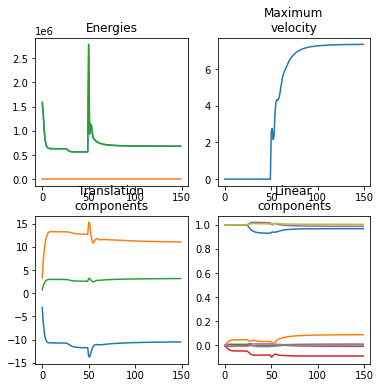

In [235]:
def generate_calibration_plots(
    affines,
    maximum_velocities,
    matching_energies,
    regularization_energies,
    total_energies,
):
    """
    Plot the energies, maximum velocities, translation components, and linear
    components as functions of the number of iterations.
    """

    fig, axs = plt.subplots(2, 2, figsize=(6, 6))

    # Plot matching, regularization, and total energies.
    ax = axs[0, 0]
    ax.plot(
        list(zip(matching_energies, regularization_energies, total_energies))
    )
    ax.set_title("Energies")

    # Plot the maximum velocity.
    ax = axs[0, 1]
    ax.plot(maximum_velocities)
    ax.set_title("Maximum\nvelocity")

    # Plot affine[:, :-1], the translation components.
    translations = [affine[:-1, -1] for affine in affines]
    ax = axs[1, 0]
    ax.plot(translations)
    ax.set_title("Translation\ncomponents")

    # Plot self.affine[:-1, :-1], the linear transformation components.
    linear_components = [affine[:-1, :-1].ravel() for affine in affines]
    ax = axs[1, 1]
    ax.plot(linear_components)
    ax.set_title("Linear\ncomponents")


# Visualize registration progression, useful for parameter tuning.
generate_calibration_plots(
    affines=lddmm_output.diagnostics.affines,
    maximum_velocities=lddmm_output.diagnostics.maximum_velocities,
    matching_energies=lddmm_output.diagnostics.matching_energies,
    regularization_energies=lddmm_output.diagnostics.regularization_energies,
    total_energies=lddmm_output.diagnostics.total_energies,
)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


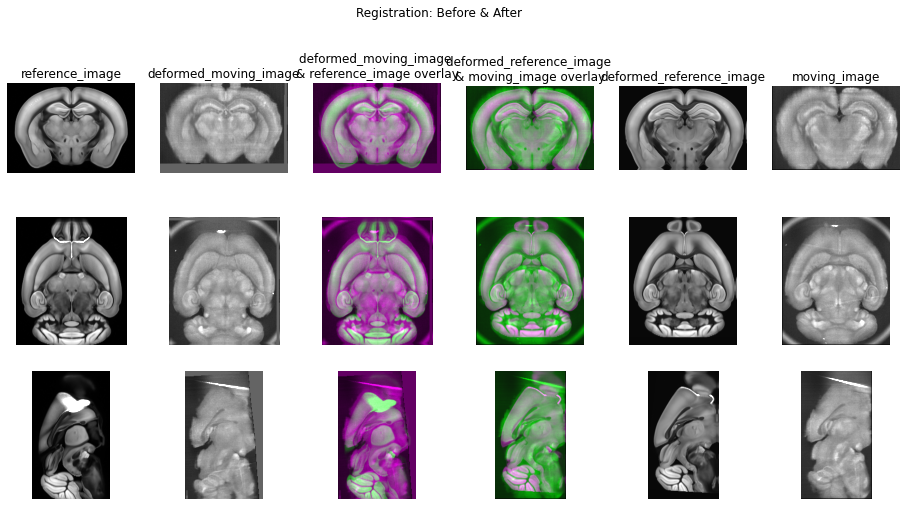

In [233]:
##############################################################################
# Apply Registration
# ------------------
#
# The registration can be reasonably applied to any image in the
# reference_image space or the moving_image space by substituting it for the
# corresponding image (reference_image or moving_image) as the input argument
# of map_coordinates and multiplying the coordinates by
# different_image.shape / replaced_image.shape. We demonstrate this by using
# rescaled versions of reference_image and moving_image to imitate different
# images in the same spaces.
#
# The registration can be applied at arbitrary spacing by first multiplying
# the coordinates by the factor change in spacing and then resampling the
# coordinates to the desired spacing. We demonstrate this by applying at the
# same spacing as our rescaled reference_image and moving_image to get
# deformed images of the same shape.
#
# The position-fields (transforms) output by the registration have the same
# shape as (share the spacing of) the reference_image and moving_image
# regardless of the scale the registration was computed at, see the
# multiscales parameter.


apply = "at native spacing"
# apply = "to different images at native spacing"
# apply = "to different images at different spacing"


# Apply registration to reference_image and moving_image at native spacing.

if apply == "at native spacing":

    deformed_moving_image = map_coordinates(
        input=moving_image,
        coordinates=lddmm_output.moving_image_to_reference_image_transform,
    )

    deformed_reference_image = map_coordinates(
        input=reference_image,
        coordinates=lddmm_output.reference_image_to_moving_image_transform,
    )

    reference_image_vis = reference_image
    moving_image_vis = moving_image


# Apply to different images
# (mocked with rescaled versions of reference_image and moving_image)
# at native spacing.

elif apply == "to different images at native spacing":

    rescaled_reference_image = rescale(
        reference_image, np.pi
    )  # This could by any image in the reference_image space.
    rescaled_moving_image = rescale(
        moving_image, np.e
    )  # This could by any image in the moving_image space.

    reference_image_scale = np.divide(
        rescaled_reference_image.shape, reference_image.shape
    )
    moving_image_scale = np.divide(
        rescaled_moving_image.shape, moving_image.shape
    )

    deformed_moving_image = map_coordinates(
        input=rescaled_moving_image,
        coordinates=lddmm_output.moving_image_to_reference_image_transform
        * moving_image_scale[:, None, None, None],
    )

    deformed_reference_image = map_coordinates(
        input=rescaled_reference_image,
        coordinates=lddmm_output.reference_image_to_moving_image_transform
        * reference_image_scale[:, None, None, None],
    )

    reference_image_vis = reference_image
    moving_image_vis = moving_image


# Apply to different images
# (mocked with rescaled versions of reference_image and moving_image)
# at a different spacing
# (at the exact shapes of rescaled_reference_image and rescaled_moving_image).

# Note: The difference between this and the above example is that the
# transformation is applied at higher spacing therefore produces deformed
# images of higher spacing. In this case it is producing deformed images of
# the same shape as their undeformed counterparts, rescaled_reference_image
# and rescaled_moving_image.

elif apply == "to different images at different spacing":

    rescaled_reference_image = rescale(reference_image, np.pi)
    rescaled_moving_image = rescale(moving_image, np.e)

    reference_image_scale = np.divide(
        rescaled_reference_image.shape, reference_image.shape
    )
    moving_image_scale = np.divide(
        rescaled_moving_image.shape, moving_image.shape
    )

    rescaled_moving_image_to_reference_image_transform = resize(
        lddmm_output.moving_image_to_reference_image_transform
        * moving_image_scale[:, None, None, None],
        (3, *rescaled_reference_image.shape),
    )
    rescaled_reference_image_to_moving_image_transform = resize(
        lddmm_output.reference_image_to_moving_image_transform
        * reference_image_scale[:, None, None, None],
        (3, *rescaled_moving_image.shape),
    )

    deformed_moving_image = map_coordinates(
        input=rescaled_moving_image,
        coordinates=rescaled_moving_image_to_reference_image_transform,
    )

    deformed_reference_image = map_coordinates(
        input=rescaled_reference_image,
        coordinates=rescaled_reference_image_to_moving_image_transform,
    )

    reference_image_vis = rescaled_reference_image
    moving_image_vis = rescaled_moving_image


##############################################################################
# Visualize Results
# -----------------
#
# By this point we have deformed versions of reference_image and moving_image,
# each deformed into the space of the other. We visualize what we have done
# by showing a central slice of six images across each axis. These different
# views are shown across rows. The images sliced, representing the columns,
# are: reference_image, moving_image deformed to the reference_image space,
# deformed_moving_image overlaid with reference_image,
# deformed_reference_image overlaid with moving_image, reference_image
# deformed to the moving_image space, and moving_image.


def scale_data(data, quantile_threshold=0.001):
    """
    Rescales data such that the central data points (ignoring the extrema) lie
    on the interval [0, 1].
    """

    data = np.copy(data)

    lower_limit = np.quantile(
        data, min(quantile_threshold, 1 - quantile_threshold)
    )
    upper_limit = np.quantile(
        data, max(quantile_threshold, 1 - quantile_threshold)
    )
    data_range = upper_limit - lower_limit

    data -= lower_limit
    data /= data_range

    return data


def imshow_on_ax(
    axs, dim, column, image, overlaid_image=None, quantile_threshold=0.001
):
    """
    Rescales image using scale_data and displays a central slice of it across
    the given dimension on the specified element of axs.

    If an overlaid_image is provided, it is likewise rescaled and an RGB
    display is produced using image as the Red and Blue channels and
    overlaid_image as the Green channel.
    """

    ax = axs[dim, column]
    ax.axis("off")

    scaled_image = scale_data(image, quantile_threshold)

    display_image = scaled_image

    if overlaid_image is not None:
        scaled_overlaid_image = scale_data(overlaid_image, quantile_threshold)
        display_image = np.stack(
            [scaled_image, scaled_overlaid_image, scaled_image], axis=-1
        )

    ax.imshow(
        display_image.take(display_image.shape[dim] // 2, axis=dim),
        cmap="gray",
        vmin=0,
        vmax=1,
    )


# Visualize results.

# Column 0: raw reference_image.
# Column 1: moving_image deformed to reference_image.
# Column 2: deformed_moving_image overlaid with reference_image.
# Column 3: deformed_reference_image overlaid with moving_image.
# Column 4: reference_image deformed to moving_image.
# Column 5: raw moving_image.

fig, axs = plt.subplots(3, 6, figsize=(16, 8))

fig.suptitle("Registration: Before & After")

# Call imshow for each subplot axs.
for dim in range(3):
    # vmin and vmax are set to saturate the top and bottom 0.1% extrema.

    # Column 0: raw reference_image.
    imshow_on_ax(axs=axs, dim=dim, column=0, image=reference_image_vis)

    # Column 1: deformed_moving_image.
    imshow_on_ax(axs=axs, dim=dim, column=1, image=deformed_moving_image)

    # Column 2: deformed_moving_image overlaid with reference_image.
    imshow_on_ax(
        axs=axs,
        dim=dim,
        column=2,
        image=deformed_moving_image,
        overlaid_image=reference_image_vis,
    )

    # Column 3: deformed_reference_image overlaid with moving_image.
    imshow_on_ax(
        axs=axs,
        dim=dim,
        column=3,
        image=deformed_reference_image,
        overlaid_image=moving_image_vis,
    )

    # Column 4: deformed_reference_image.
    imshow_on_ax(axs=axs, dim=dim, column=4, image=deformed_reference_image)

    # Column 5: raw moving_image.
    imshow_on_ax(axs=axs, dim=dim, column=5, image=moving_image_vis)


# Set column labels.
for ax, column_label in zip(
    axs[0],
    [
        "reference_image",
        "deformed_moving_image",
        "deformed_moving_image \n& reference_image overlay",
        "deformed_reference_image \n& moving_image overlay",
        "deformed_reference_image",
        "moving_image",
    ],
):
    ax.set_title(column_label)


# Set row labels.
for ax, row_index in zip(axs[:, 0], range(len(axs))):
    row_label = f"Dimension {row_index}"
    ax.set_ylabel(row_label, rotation="vertical")